
# Baseline Experiment 1

Train model from scratch for each subject. 

Model: BSFShallowNet

Dataset: BCI Competitin IV 2a, BCNI2014001 via MOABB library


In [134]:
import matplotlib.pyplot as plt
from braindecode.datasets import MOABBDataset
from numpy import multiply
from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os
import pickle
from matplotlib.lines import Line2D
# from braindecode.visualization import plot_confusion_matrix

from braindecode.datasets import BaseConcatDataset
from braindecode.datasets.base import EEGWindowsDataset
from braindecode.preprocessing.windowers import _create_windows_from_events
import numpy as np
import mne
import random

## Loading and preparing the data




### Loading the dataset




In [87]:
# subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=list(range(1, 10)))

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|#############################################| 44.6M/44.6M [00:00<?, ?B/s]
SHA256 hash of downloaded file: 4dc3be1b0d60279134d1220323c73c68cf73799339a7fb224087a3c560a9a7e2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|##################

### Preprocessing




In [92]:
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


### Extracting Compute Windows




In [93]:
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [33]:
def get_subset(window_set, target_trial_num):
    new_ds_lst = []
    
    for ds in window_set.datasets:
        cur_run_trial_num = len(ds.metadata)
        if target_trial_num > cur_run_trial_num:
            new_ds_lst.append(ds)
            target_trial_num -= cur_run_trial_num
        else:
            new_ds_lst.append(EEGWindowsDataset(ds.raw, ds.metadata[:target_trial_num], description=ds.description[:target_trial_num]))
            break

    return BaseConcatDataset(new_ds_lst)

## Creating a model




In [39]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

## Model Training




In [103]:
dict_results = {}

for subj_id, subj_dataset in windows_dataset.split('subject').items():

    dict_subj_results = {}
    
    cur_splitted = subj_dataset.split('session')
    subj_train_set = splitted['0train']
    subj_valid_set = splitted['1test']
    train_trials_num = len(subj_train_set.get_metadata())

    for training_data_amount in np.arange(1, train_trials_num//10)*10:
    
        cur_model = ShallowFBCSPNet(
            n_chans,
            n_classes,
            input_window_samples=input_window_samples,
            final_conv_length='auto',
        )
        
        lr = 0.0625 * 0.01
        weight_decay = 0
        # batch_size = 64
        batch_size = int(min(training_data_amount // 2, 64))
        n_epochs = 40
    
        # Re-initialize EEGClassifier
        cur_clf = EEGClassifier(
            cur_model,
            criterion=torch.nn.NLLLoss,
            optimizer=torch.optim.AdamW,
            train_split=predefined_split(subj_valid_set),  # using valid_set for validation
            optimizer__lr=lr,
            optimizer__weight_decay=weight_decay,
            batch_size=batch_size,
            callbacks=[
                "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
            ],
            device=device,
            classes=classes,
        )
    
        # Get current training set
        cur_train_set = get_subset(subj_train_set, training_data_amount)
    
        # Fit model
        print(f'Training model for subject {subj_id} with {training_data_amount} trials')
        _ = cur_clf.fit(cur_train_set, y=None, epochs=n_epochs)
    
        # results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
        results_columns = ['valid_accuracy',]
        df = pd.DataFrame(cur_clf.history[:, results_columns], columns=results_columns,
                          index=cur_clf.history[:, 'epoch'])
        
        # get percent of misclass for better visual comparison to loss
        # df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
        #                valid_misclass=100 - 100 * df.valid_accuracy)
    
        cur_final_acc = np.mean(df.tail(5).valid_accuracy)
        dict_subj_results.update({training_data_amount: cur_final_acc})

    dict_results.update({subj_id: dict_subj_results})

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Training model for subject 1 with 10 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        2.2982       0.2188            0.2188        3.4029  0.0006  0.3629
      2            0.3000        1.4780       0.2500            0.2500        2.9980  0.0006  0.3207
      3            0.3000        0.5364       0.2500            0.2500        3.1499  0.0006  0.3303
      4            0.4000        0.5146       0.2431            0.2431        3.2865  0.0006  0.3356
      5            0.8000        0.4008       0.2569            0.2569        3.5582  0.0006  0.3323
      6            0.8000        0.1817       0.2465            0.2465        3.6862  0.0006  0.3342
      7            0.8000        0.0910       0.2431            0.2431        3.7328  0.0006  0.3130
      8            0.9000        0.1503       0

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5500        1.6643       0.3021            0.3021        1.4681  0.0006  0.2991
      2            0.9000        1.0510       0.3194            0.3194        1.7377  0.0006  0.2931
      3            0.9000        0.7156       0.3403            0.3403        1.9787  0.0006  0.2911
      4            0.8500        0.5472       0.3333            0.3333        2.2011  0.0006  0.2866
      5            0.9000        0.2576       0.3229            0.3229        2.2855  0.0006  0.2783
      6            0.9000        0.1668       0.3160            0.3160        2.3164  0.0006  0.2652
      7            0.9000        0.2726       0.3299            0.3299        2.2012  0.0006  0.2752
      8            0.9000        0.2080       0.3194            0.3194        2.0953  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.6866       0.2500            0.2500        3.0832  0.0006  0.2723
      2            0.3000        1.2495       0.2535            0.2535        3.0234  0.0006  0.2540
      3            0.4667        0.9231       0.2569            0.2569        2.5564  0.0006  0.2520
      4            0.7333        0.5831       0.2917            0.2917        2.2145  0.0006  0.2622
      5            0.8000        0.4505       0.2778            0.2778        2.1134  0.0006  0.2618
      6            0.8000        0.4270       0.2847            0.2847        2.1452  0.0006  0.2660
      7            0.8000        0.3991       0.2847            0.2847        2.3188  0.0006  0.2626
      8            0.7333        0.3503       0.2951            0.2951        2.5425  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3750        1.5510       0.2604            0.2604        1.8893  0.0006  0.2695
      2            0.6500        1.1274       0.2986            0.2986        1.8937  0.0006  0.2808
      3            0.6750        0.8179       0.3160            0.3160        1.9248  0.0006  0.2781
      4            0.7750        0.7220       0.3472            0.3472        1.9064  0.0006  0.3460
      5            0.8000        0.5466       0.3194            0.3194        1.9940  0.0006  0.3442
      6            0.8000        0.4462       0.3264            0.3264        2.0511  0.0006  0.3288
      7            0.8000        0.4617       0.3229            0.3229        2.0902  0.0006  0.3522
      8            0.8000        0.4007       0.3056            0.3056        2.1159  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3200        1.6192       0.2917            0.2917        1.9510  0.0006  0.2812
      2            0.6600        1.0424       0.3194            0.3194        1.6901  0.0006  0.2721
      3            0.6200        0.9915       0.2917            0.2917        1.7181  0.0006  0.2922
      4            0.4800        0.8046       0.2778            0.2778        2.0094  0.0006  0.2800
      5            0.4400        0.7574       0.2604            0.2604        2.3615  0.0006  0.2846
      6            0.4600        0.4981       0.2674            0.2674        2.4746  0.0006  0.2931
      7            0.4600        0.4901       0.2708            0.2708        2.5536  0.0006  0.2931
      8            0.5200        0.4664       0.2743            0.2743        2.5831  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2833        1.4789       0.2604            0.2604        2.8053  0.0006  0.2937
      2            0.4833        1.2301       0.2951            0.2951        1.7438  0.0006  0.3049
      3            0.5333        0.8592       0.2917            0.2917        1.7776  0.0006  0.2886
      4            0.2667        0.8672       0.2500            0.2500        2.9712  0.0006  0.2905
      5            0.2333        0.6956       0.2500            0.2500        3.7268  0.0006  0.2970
      6            0.2333        0.6456       0.2500            0.2500        4.1003  0.0006  0.3029
      7            0.2333        0.5226       0.2500            0.2500        4.1660  0.0006  0.3085
      8            0.2667        0.4734       0.2500            0.2500        3.8728  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3571        1.8348       0.2708            0.2708        3.2455  0.0006  0.3183
      2            0.2857        1.3973       0.2708            0.2708        2.5342  0.0006  0.2971
      3            0.2714        1.2372       0.2569            0.2569        2.6616  0.0006  0.2966
      4            0.2714        0.8937       0.2569            0.2569        2.7762  0.0006  0.3205
      5            0.3143        0.8270       0.2569            0.2569        2.7172  0.0006  0.3062
      6            0.4000        0.7794       0.2639            0.2639        2.6927  0.0006  0.3193
      7            0.4714        0.6229       0.2812            0.2812        2.7173  0.0006  0.3115
      8            0.5286        0.5857       0.2847            0.2847        2.6449  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4125        1.7256       0.2951            0.2951        1.9120  0.0006  0.3274
      2            0.2625        1.4013       0.2500            0.2500        3.0230  0.0006  0.4159
      3            0.2625        0.9630       0.2500            0.2500        4.1212  0.0006  0.3225
      4            0.2625        1.0230       0.2500            0.2500        4.3392  0.0006  0.3251
      5            0.2625        0.8383       0.2500            0.2500        4.4880  0.0006  0.3209
      6            0.2625        0.7436       0.2500            0.2500        4.4216  0.0006  0.3279
      7            0.2625        0.6357       0.2500            0.2500        4.0953  0.0006  0.3304
      8            0.3250        0.5622       0.2500            0.2500        3.7997  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3111        1.8406       0.2812            0.2812        2.2227  0.0006  0.3449
      2            0.2556        1.3969       0.2535            0.2535        2.9164  0.0006  0.3257
      3            0.3111        1.1027       0.2708            0.2708        2.6382  0.0006  0.3447
      4            0.3556        1.0358       0.2847            0.2847        2.5076  0.0006  0.3452
      5            0.4444        0.8992       0.2951            0.2951        2.2347  0.0006  0.3230
      6            0.5778        0.8612       0.3229            0.3229        2.0431  0.0006  0.3385
      7            0.5889        0.7937       0.3264            0.3264        2.0179  0.0006  0.3357
      8            0.6444        0.7433       0.3229            0.3229        2.0118  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6355       0.2500            0.2500        4.0259  0.0006  0.3491
      2            0.4000        1.3069       0.3229            0.3229        2.3674  0.0006  0.3421
      3            0.3300        1.1612       0.3056            0.3056        2.5432  0.0006  0.3442
      4            0.3900        1.0088       0.3160            0.3160        2.7386  0.0006  0.3480
      5            0.4500        0.8566       0.3299            0.3299        2.9246  0.0006  0.3548
      6            0.4800        0.7835       0.3333            0.3333        3.0054  0.0006  0.3568
      7            0.4800        0.7024       0.3333            0.3333        3.0494  0.0006  0.3528
      8            0.4800        0.6258       0.3194            0.3194        2.9569  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3455        1.4293       0.3264            0.3264        2.8555  0.0006  0.4119
      2            0.4091        1.1691       0.3507            0.3507        2.9555  0.0006  0.4104
      3            0.3909        0.9489       0.3299            0.3299        2.9597  0.0006  0.4026
      4            0.4182        0.9035       0.3438            0.3438        2.7840  0.0006  0.3651
      5            0.4273        0.7751       0.3542            0.3542        2.7362  0.0006  0.3565
      6            0.4727        0.6970       0.3715            0.3715        2.5510  0.0006  0.3626
      7            0.5000        0.7125       0.3785            0.3785        2.3283  0.0006  0.3941
      8            0.5455        0.6326       0.3785            0.3785        2.1151  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2583        1.4914       0.2500            0.2500        5.9704  0.0006  0.3913
      2            0.2583        1.3150       0.2500            0.2500        5.2339  0.0006  0.3704
      3            0.2750        1.1486       0.2535            0.2535        4.3426  0.0006  0.3711
      4            0.3500        1.0295       0.2743            0.2743        3.9981  0.0006  0.3706
      5            0.3667        0.8681       0.2847            0.2847        4.1046  0.0006  0.4026
      6            0.4333        0.8376       0.3125            0.3125        3.9607  0.0006  0.3794
      7            0.4667        0.7527       0.3403            0.3403        3.7859  0.0006  0.4736
      8            0.4667        0.7126       0.3472            0.3472        3.5903  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3154        1.5731       0.2292            0.2292        1.8580  0.0006  0.4783
      2            0.3615        1.4398       0.2396            0.2396        2.4832  0.0006  0.4484
      3            0.2923        1.2508       0.2674            0.2674        2.7122  0.0006  0.4493
      4            0.4385        1.0642       0.3542            0.3542        2.5325  0.0006  0.4799
      5            0.4923        0.9814       0.3542            0.3542        2.4231  0.0006  0.4936
      6            0.4615        0.9541       0.3472            0.3472        2.3673  0.0006  0.4836
      7            0.5000        0.8550       0.3715            0.3715        2.2141  0.0006  0.3870
      8            0.5462        0.7763       0.3646            0.3646        2.1304  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5812       0.2500            0.2500        4.4005  0.0006  0.3910
      2            0.2500        1.3813       0.2500            0.2500        4.7601  0.0006  0.3863
      3            0.2500        1.2194       0.2500            0.2500        4.4699  0.0006  0.3886
      4            0.2714        1.0539       0.2604            0.2604        4.3069  0.0006  0.3871
      5            0.2714        1.0482       0.2604            0.2604        4.4426  0.0006  0.3991
      6            0.2714        0.8851       0.2639            0.2639        4.3613  0.0006  0.4014
      7            0.3000        0.8635       0.2743            0.2743        4.0287  0.0006  0.3841
      8            0.3286        0.7810       0.2882            0.2882        3.7679  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2933        1.5054       0.2431            0.2431        2.7703  0.0006  0.3860
      2            0.3067        1.2618       0.2639            0.2639        2.2154  0.0006  0.3923
      3            0.3667        1.0390       0.2847            0.2847        2.0781  0.0006  0.3998
      4            0.3933        1.0387       0.3403            0.3403        2.3894  0.0006  0.3802
      5            0.4333        0.9434       0.3472            0.3472        2.5954  0.0006  0.3846
      6            0.5067        0.8419       0.3854            0.3854        2.4991  0.0006  0.3816
      7            0.5000        0.7914       0.3889            0.3889        2.4142  0.0006  0.3841
      8            0.5067        0.6638       0.3889            0.3889        2.3347  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3187        1.7572       0.2708            0.2708        3.1536  0.0006  0.3951
      2            0.3000        1.3609       0.2743            0.2743        2.9402  0.0006  0.3848
      3            0.2687        1.2740       0.2604            0.2604        3.2860  0.0006  0.3814
      4            0.3000        1.1226       0.2743            0.2743        3.0267  0.0006  0.4388
      5            0.3312        0.9948       0.2951            0.2951        2.9455  0.0006  0.4228
      6            0.3438        0.9777       0.3021            0.3021        2.9698  0.0006  0.4482
      7            0.3937        0.8233       0.3160            0.3160        2.9364  0.0006  0.4507
      8            0.3688        0.9017       0.3021            0.3021        2.9618  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2412        1.6783       0.2500            0.2500        2.9122  0.0006  0.3944
      2            0.2412        1.4955       0.2465            0.2465        2.1993  0.0006  0.4007
      3            0.3588        1.1467       0.2535            0.2535        1.9698  0.0006  0.3888
      4            0.4176        1.1500       0.2361            0.2361        2.0626  0.0006  0.3965
      5            0.3000        1.0927       0.2465            0.2465        2.3896  0.0006  0.3828
      6            0.2706        0.9622       0.2535            0.2535        2.5708  0.0006  0.3809
      7            0.2647        0.9556       0.2535            0.2535        2.7709  0.0006  0.3847
      8            0.2588        0.9864       0.2535            0.2535        2.7940  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.7915       0.2500            0.2500        5.6283  0.0006  0.4028
      2            0.3500        1.4047       0.2778            0.2778        4.0597  0.0006  0.3846
      3            0.2611        1.2848       0.2569            0.2569        4.3555  0.0006  0.4113
      4            0.3000        1.1809       0.2604            0.2604        3.9243  0.0006  0.3867
      5            0.3556        1.0905       0.2639            0.2639        3.5954  0.0006  0.3768
      6            0.4389        1.0210       0.2812            0.2812        3.0936  0.0006  0.3892
      7            0.4278        0.8662       0.2986            0.2986        2.7450  0.0006  0.3909
      8            0.4556        0.9261       0.2986            0.2986        2.5038  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2526        1.7845       0.2500            0.2500        4.4720  0.0006  0.3968
      2            0.2526        1.3613       0.2500            0.2500        3.6054  0.0006  0.3779
      3            0.2684        1.5185       0.2500            0.2500        2.5414  0.0006  0.3829
      4            0.3474        1.0997       0.2639            0.2639        2.4695  0.0006  0.3834
      5            0.2579        1.1364       0.2465            0.2465        2.5694  0.0006  0.3827
      6            0.2947        1.0934       0.2396            0.2396        2.4892  0.0006  0.5064
      7            0.3842        0.9973       0.2604            0.2604        2.3374  0.0006  0.4868
      8            0.4368        0.9000       0.2674            0.2674        2.1080  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3500        1.6239       0.2431            0.2431        2.3148  0.0006  0.5024
      2            0.3850        1.2479       0.2396            0.2396        3.1220  0.0006  0.5156
      3            0.3800        1.1752       0.2396            0.2396        2.9049  0.0006  0.4794
      4            0.4000        1.0115       0.2361            0.2361        2.3116  0.0006  0.5064
      5            0.4700        0.9886       0.2639            0.2639        1.9387  0.0006  0.5093
      6            0.4550        0.9236       0.2535            0.2535        1.9101  0.0006  0.5147
      7            0.4400        0.8747       0.2743            0.2743        1.8924  0.0006  0.4901
      8            0.5200        0.8372       0.2847            0.2847        1.8257  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2524        1.6638       0.2500            0.2500        3.6374  0.0006  0.4857
      2            0.2810        1.2732       0.2535            0.2535        2.2906  0.0006  0.4872
      3            0.4143        1.1415       0.2535            0.2535        2.2559  0.0006  0.8317
      4            0.4000        1.0325       0.2708            0.2708        2.5813  0.0006  0.6436
      5            0.3143        0.9689       0.2674            0.2674        2.5964  0.0006  0.5772
      6            0.3238        0.9493       0.2743            0.2743        2.4171  0.0006  0.6074
      7            0.4095        0.8608       0.2812            0.2812        2.0560  0.0006  0.6559
      8            0.4905        0.8214       0.2847            0.2847        1.9081  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2591        1.6372       0.2500            0.2500        3.8500  0.0006  0.4916
      2            0.2591        1.4226       0.2500            0.2500        3.3534  0.0006  0.4905
      3            0.3091        1.1151       0.2674            0.2674        2.0554  0.0006  0.4939
      4            0.3182        1.0252       0.2708            0.2708        2.0989  0.0006  0.4882
      5            0.2773        0.9809       0.2674            0.2674        2.2641  0.0006  0.4859
      6            0.2727        0.9057       0.2604            0.2604        2.3631  0.0006  0.5083
      7            0.3591        0.9374       0.2535            0.2535        2.0448  0.0006  0.4848
      8            0.4455        0.8646       0.2674            0.2674        1.8359  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3304        1.6078       0.2917            0.2917        3.1373  0.0006  0.4969
      2            0.3000        1.3594       0.2708            0.2708        3.0488  0.0006  0.4902
      3            0.4000        1.1586       0.2986            0.2986        2.4433  0.0006  0.5100
      4            0.4696        1.0609       0.3090            0.3090        1.9640  0.0006  0.5108
      5            0.3739        1.0157       0.2743            0.2743        1.8866  0.0006  0.4833
      6            0.3348        0.9392       0.2674            0.2674        2.1833  0.0006  0.4875
      7            0.3522        0.9573       0.2674            0.2674        2.1134  0.0006  0.4890
      8            0.4783        0.8041       0.2847            0.2847        1.8605  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6125       0.2500            0.2500        5.5449  0.0006  0.5151
      2            0.2500        1.3235       0.2535            0.2535        4.3986  0.0006  0.5669
      3            0.3875        1.1944       0.2917            0.2917        3.5050  0.0006  0.6033
      4            0.3458        1.1420       0.2535            0.2535        3.0809  0.0006  0.6080
      5            0.4125        1.0487       0.2743            0.2743        2.6677  0.0006  0.5870
      6            0.4000        1.0288       0.2778            0.2778        2.3827  0.0006  0.5396
      7            0.4542        0.8880       0.2847            0.2847        2.0631  0.0006  0.5301
      8            0.5625        0.8759       0.3333            0.3333        1.7010  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2520        1.6983       0.2500            0.2500        4.0342  0.0006  0.4896
      2            0.2560        1.3243       0.2500            0.2500        3.0389  0.0006  0.4829
      3            0.2800        1.2546       0.2569            0.2569        2.6406  0.0006  0.4852
      4            0.2880        1.1199       0.2569            0.2569        2.4924  0.0006  0.5020
      5            0.3240        1.0100       0.2708            0.2708        2.4495  0.0006  0.4976
      6            0.4480        0.8831       0.2917            0.2917        2.2101  0.0006  0.4874
      7            0.4880        0.9055       0.3056            0.3056        2.0085  0.0006  0.4857
      8            0.5680        0.7950       0.3403            0.3403        1.7201  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2846        1.5813       0.2639            0.2639        2.4485  0.0006  0.6248
      2            0.2462        1.2413       0.2535            0.2535        2.8871  0.0006  0.7289
      3            0.2846        1.0888       0.2569            0.2569        2.8229  0.0006  0.6860
      4            0.4077        1.0079       0.2396            0.2396        2.3271  0.0006  0.6030
      5            0.3615        0.8978       0.2569            0.2569        2.0657  0.0006  0.6125
      6            0.4231        0.8503       0.2743            0.2743        1.8590  0.0006  0.5956
      7            0.5731        0.7764       0.3333            0.3333        1.5983  0.0006  0.5816
      8            0.7462        0.6359       0.4132            0.4132        1.3523  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2778        1.6688       0.2569            0.2569        3.2888  0.0006  0.5997
      2            0.3481        1.3090       0.2535            0.2535        1.9551  0.0006  0.5905
      3            0.3926        1.1552       0.2500            0.2500        1.9214  0.0006  0.5910
      4            0.4148        1.0051       0.2639            0.2639        2.1161  0.0006  0.6073
      5            0.5185        1.0182       0.2778            0.2778        1.8816  0.0006  0.5924
      6            0.6185        0.8445       0.3576            0.3576        1.5891  0.0006  0.5833
      7            0.7333        0.8281       0.4028            0.4028        1.4195  0.0006  0.6050
      8            0.7852        0.8265       0.4444            0.4444        1.3190  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.1000        1.6764       0.2465            0.2465        2.8658  0.0006  0.3146
      2            0.6000        0.6832       0.2465            0.2465        1.7711  0.0006  0.3297
      3            0.8000        0.6482       0.2743            0.2743        2.0558  0.0006  0.3104
      4            0.9000        0.3663       0.2639            0.2639        2.5975  0.0006  0.3183
      5            0.9000        0.2358       0.2500            0.2500        2.9248  0.0006  0.3239
      6            0.8000        0.2097       0.2639            0.2639        3.1030  0.0006  0.3266
      7            0.9000        0.0959       0.2500            0.2500        3.1470  0.0006  0.3158
      8            1.0000        0.0538       0.2431            0.2431        3.0864  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4500        1.9317       0.2604            0.2604        1.7197  0.0006  0.2828
      2            0.6500        1.1463       0.2535            0.2535        1.8980  0.0006  0.2634
      3            0.8000        0.7197       0.2639            0.2639        2.1333  0.0006  0.2631
      4            0.8500        0.5055       0.2604            0.2604        2.1738  0.0006  0.2810
      5            0.9000        0.3787       0.2708            0.2708        2.1794  0.0006  0.2610
      6            0.9500        0.2689       0.2882            0.2882        2.1362  0.0006  0.2771
      7            1.0000        0.2299       0.3090            0.3090        2.0456  0.0006  0.2671
      8            1.0000        0.1869       0.3333            0.3333        2.0062  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.7166       0.2986            0.2986        2.1777  0.0006  0.3011
      2            0.4667        1.0649       0.3333            0.3333        2.8704  0.0006  0.2667
      3            0.4667        0.7622       0.3264            0.3264        3.3644  0.0006  0.3004
      4            0.4667        0.5444       0.3472            0.3472        3.4712  0.0006  0.2692
      5            0.4667        0.5136       0.3576            0.3576        3.3519  0.0006  0.2797
      6            0.4667        0.2840       0.3646            0.3646        3.2639  0.0006  0.2667
      7            0.5333        0.2520       0.3646            0.3646        3.0975  0.0006  0.2809
      8            0.6000        0.1739       0.3611            0.3611        2.9685  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.7146       0.2500            0.2500        3.3237  0.0006  0.2713
      2            0.3500        1.3062       0.2500            0.2500        2.7874  0.0006  0.2733
      3            0.5500        0.9850       0.2465            0.2465        2.5437  0.0006  0.2743
      4            0.6250        0.8534       0.2396            0.2396        2.6543  0.0006  0.2932
      5            0.6250        0.6384       0.2257            0.2257        2.6024  0.0006  0.3489
      6            0.6250        0.5033       0.2500            0.2500        2.3946  0.0006  0.3432
      7            0.6500        0.3894       0.2500            0.2500        2.2623  0.0006  0.3609
      8            0.7500        0.3656       0.2431            0.2431        2.1293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2600        2.0314       0.2500            0.2500        7.6882  0.0006  0.2984
      2            0.2600        1.5088       0.2500            0.2500        7.0345  0.0006  0.2735
      3            0.2600        0.9580       0.2500            0.2500        6.6867  0.0006  0.2898
      4            0.2600        0.8566       0.2500            0.2500        6.6003  0.0006  0.2750
      5            0.2600        0.7320       0.2500            0.2500        6.4477  0.0006  0.2967
      6            0.2600        0.5998       0.2500            0.2500        6.1140  0.0006  0.2841
      7            0.2600        0.3845       0.2500            0.2500        5.6146  0.0006  0.2810
      8            0.2600        0.5512       0.2500            0.2500        5.0556  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.9712       0.2708            0.2708        1.7138  0.0006  0.3045
      2            0.3833        1.3589       0.2743            0.2743        2.1570  0.0006  0.2906
      3            0.2667        1.1690       0.2569            0.2569        3.3170  0.0006  0.2877
      4            0.2500        0.9566       0.2535            0.2535        3.8084  0.0006  0.2958
      5            0.2500        0.7743       0.2535            0.2535        4.1520  0.0006  0.2929
      6            0.2667        0.7015       0.2535            0.2535        3.9485  0.0006  0.3006
      7            0.3000        0.6377       0.2535            0.2535        3.6613  0.0006  0.2957
      8            0.4000        0.6344       0.2569            0.2569        3.4114  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3571        1.6102       0.2986            0.2986        3.7281  0.0006  0.3145
      2            0.4286        1.2440       0.3507            0.3507        3.4295  0.0006  0.3068
      3            0.4571        1.1932       0.3438            0.3438        2.6204  0.0006  0.3091
      4            0.4286        0.8372       0.2743            0.2743        2.4810  0.0006  0.3137
      5            0.4143        0.7831       0.2639            0.2639        2.5495  0.0006  0.3197
      6            0.4286        0.6613       0.2639            0.2639        2.5844  0.0006  0.3055
      7            0.4571        0.6772       0.2639            0.2639        2.6502  0.0006  0.3132
      8            0.4857        0.4996       0.2674            0.2674        2.6542  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.8796       0.2500            0.2500        3.5585  0.0006  0.4324
      2            0.2500        1.4332       0.2535            0.2535        2.4087  0.0006  0.3194
      3            0.4375        1.1367       0.3264            0.3264        1.8271  0.0006  0.3297
      4            0.5000        0.9563       0.3438            0.3438        1.9306  0.0006  0.3341
      5            0.5125        0.7877       0.3299            0.3299        2.1122  0.0006  0.3229
      6            0.5125        0.7466       0.3021            0.3021        2.2139  0.0006  0.3220
      7            0.5625        0.7134       0.3194            0.3194        2.2076  0.0006  0.3425
      8            0.6750        0.6593       0.3264            0.3264        2.1192  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.6404       0.2951            0.2951        2.1741  0.0006  0.3472
      2            0.3333        1.2656       0.2569            0.2569        2.3852  0.0006  0.3488
      3            0.4222        1.0576       0.2639            0.2639        2.8403  0.0006  0.3383
      4            0.4556        1.0214       0.2743            0.2743        2.8956  0.0006  0.3288
      5            0.4556        0.9147       0.2812            0.2812        2.7807  0.0006  0.3438
      6            0.4333        0.7764       0.2708            0.2708        2.6914  0.0006  0.3381
      7            0.4778        0.6680       0.2778            0.2778        2.4740  0.0006  0.3234
      8            0.5778        0.6597       0.2917            0.2917        2.1819  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2700        1.6762       0.2674            0.2674        2.5424  0.0006  0.3503
      2            0.4800        1.3822       0.3472            0.3472        1.8950  0.0006  0.3649
      3            0.4600        1.2005       0.2847            0.2847        1.9301  0.0006  0.3502
      4            0.4100        0.9310       0.2674            0.2674        2.1181  0.0006  0.3774
      5            0.3600        0.9032       0.2743            0.2743        2.3338  0.0006  0.3619
      6            0.4200        0.8066       0.2778            0.2778        2.4198  0.0006  0.3565
      7            0.4200        0.7737       0.2986            0.2986        2.4754  0.0006  0.3545
      8            0.4700        0.8110       0.3021            0.3021        2.4805  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3727        1.6886       0.3090            0.3090        1.7587  0.0006  0.3748
      2            0.4091        1.3339       0.2778            0.2778        1.6658  0.0006  0.3674
      3            0.3909        1.1153       0.2743            0.2743        1.7082  0.0006  0.4592
      4            0.3182        1.0170       0.2743            0.2743        2.0533  0.0006  0.3819
      5            0.4364        0.8957       0.3229            0.3229        2.0639  0.0006  0.4362
      6            0.4818        0.8505       0.3229            0.3229        2.1551  0.0006  0.3593
      7            0.5818        0.7734       0.3576            0.3576        1.9909  0.0006  0.3637
      8            0.6364        0.6984       0.3576            0.3576        1.8494  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2333        1.5016       0.2500            0.2500        3.5408  0.0006  0.3946
      2            0.3333        1.2464       0.2812            0.2812        1.7660  0.0006  0.3790
      3            0.5000        1.1684       0.3160            0.3160        1.8661  0.0006  0.3802
      4            0.5250        0.9408       0.3333            0.3333        1.9812  0.0006  0.3789
      5            0.5667        0.8286       0.3542            0.3542        1.8953  0.0006  0.3811
      6            0.6250        0.8049       0.3611            0.3611        1.7971  0.0006  0.3778
      7            0.6917        0.6926       0.3819            0.3819        1.6463  0.0006  0.3702
      8            0.7083        0.6591       0.3819            0.3819        1.6123  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2615        1.5392       0.2500            0.2500        3.5063  0.0006  0.5082
      2            0.3385        1.2707       0.2674            0.2674        2.4956  0.0006  0.4621
      3            0.4231        1.0921       0.2812            0.2812        2.2488  0.0006  0.4832
      4            0.4231        1.0238       0.2708            0.2708        1.9605  0.0006  0.4558
      5            0.3615        0.9061       0.2882            0.2882        1.9936  0.0006  0.4799
      6            0.3231        0.9148       0.2882            0.2882        2.1980  0.0006  0.4821
      7            0.3231        0.7531       0.2917            0.2917        2.3925  0.0006  0.5018
      8            0.3462        0.7677       0.3090            0.3090        2.4006  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3214        1.5901       0.2535            0.2535        3.4003  0.0006  0.4007
      2            0.4214        1.2947       0.2986            0.2986        2.8299  0.0006  0.4016
      3            0.4071        1.1903       0.2882            0.2882        2.6812  0.0006  0.3873
      4            0.4857        0.9936       0.3056            0.3056        2.3395  0.0006  0.3749
      5            0.5643        0.9221       0.3750            0.3750        2.2255  0.0006  0.3885
      6            0.5500        0.8364       0.3472            0.3472        2.2297  0.0006  0.3904
      7            0.5143        0.8107       0.3403            0.3403        2.2856  0.0006  0.3751
      8            0.5000        0.7143       0.3403            0.3403        2.2894  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2533        1.5025       0.2500            0.2500        3.5784  0.0006  0.3939
      2            0.2467        1.3380       0.2500            0.2500        4.4236  0.0006  0.4132
      3            0.2467        1.1780       0.2500            0.2500        4.7093  0.0006  0.3955
      4            0.2467        1.1116       0.2500            0.2500        4.4035  0.0006  0.3817
      5            0.2800        1.0238       0.2674            0.2674        3.8483  0.0006  0.3974
      6            0.3400        0.8893       0.2917            0.2917        3.4885  0.0006  0.3848
      7            0.4133        0.8784       0.3229            0.3229        3.2560  0.0006  0.4252
      8            0.4667        0.8845       0.3750            0.3750        3.0253  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3625        1.6098       0.3229            0.3229        3.5517  0.0006  0.3878
      2            0.2875        1.4059       0.2812            0.2812        4.5644  0.0006  0.4019
      3            0.3625        1.2167       0.3056            0.3056        4.3683  0.0006  0.3975
      4            0.4062        1.0054       0.3194            0.3194        3.7004  0.0006  0.3834
      5            0.3563        0.9730       0.2882            0.2882        3.4868  0.0006  0.3837
      6            0.3500        1.0282       0.2812            0.2812        3.3522  0.0006  0.4054
      7            0.3063        0.8793       0.2639            0.2639        3.4163  0.0006  0.4515
      8            0.3063        0.8802       0.2604            0.2604        3.3612  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2588        1.7583       0.2569            0.2569        4.5462  0.0006  0.4810
      2            0.3706        1.2937       0.2708            0.2708        3.5075  0.0006  0.4686
      3            0.2588        1.2766       0.2569            0.2569        3.4170  0.0006  0.4074
      4            0.2471        1.1265       0.2500            0.2500        4.2025  0.0006  0.4005
      5            0.2471        0.9907       0.2500            0.2500        4.9416  0.0006  0.3991
      6            0.2471        0.9208       0.2500            0.2500        5.0931  0.0006  0.3984
      7            0.2471        0.8947       0.2535            0.2535        4.6898  0.0006  0.5576
      8            0.2647        0.9036       0.2569            0.2569        4.1086  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2722        1.5525       0.2431            0.2431        2.7221  0.0006  0.4004
      2            0.3833        1.4410       0.2986            0.2986        1.8733  0.0006  0.4027
      3            0.3611        1.2743       0.2882            0.2882        1.8844  0.0006  0.3882
      4            0.3389        1.2217       0.2431            0.2431        2.5379  0.0006  0.4145
      5            0.3444        1.0131       0.2500            0.2500        2.9778  0.0006  0.3883
      6            0.3000        1.0250       0.2569            0.2569        3.1655  0.0006  0.3927
      7            0.2833        0.9715       0.2674            0.2674        3.3200  0.0006  0.3865
      8            0.2889        0.8837       0.2708            0.2708        3.1210  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2526        1.7805       0.2500            0.2500        3.9670  0.0006  0.4016
      2            0.2579        1.4375       0.2500            0.2500        3.2371  0.0006  0.3885
      3            0.2579        1.2969       0.2500            0.2500        2.9607  0.0006  0.3843
      4            0.2632        1.1664       0.2604            0.2604        2.8580  0.0006  0.3981
      5            0.3842        1.1144       0.2708            0.2708        2.6177  0.0006  0.3831
      6            0.4842        1.0784       0.2604            0.2604        2.3810  0.0006  0.3826
      7            0.4842        1.0420       0.2812            0.2812        2.2936  0.0006  0.4454
      8            0.4842        0.8883       0.2604            0.2604        2.1441  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5847       0.2500            0.2500        4.0374  0.0006  0.6192
      2            0.2500        1.3106       0.2500            0.2500        2.7259  0.0006  0.4937
      3            0.3950        1.1568       0.2639            0.2639        2.0095  0.0006  0.5080
      4            0.4800        1.0115       0.2847            0.2847        1.8422  0.0006  0.4919
      5            0.5600        0.8725       0.2847            0.2847        1.7008  0.0006  0.4844
      6            0.5750        0.8058       0.2951            0.2951        1.7344  0.0006  0.5071
      7            0.6400        0.8215       0.3194            0.3194        1.6182  0.0006  0.5123
      8            0.7200        0.7545       0.3576            0.3576        1.4754  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.6556       0.2604            0.2604        2.7123  0.0006  0.5095
      2            0.2524        1.3626       0.2500            0.2500        2.5728  0.0006  0.6030
      3            0.3238        1.1783       0.2882            0.2882        2.2232  0.0006  0.4966
      4            0.3571        1.1095       0.2743            0.2743        1.9819  0.0006  0.5974
      5            0.5333        0.9894       0.2951            0.2951        2.0300  0.0006  0.5992
      6            0.5190        0.9300       0.2708            0.2708        2.1825  0.0006  0.5905
      7            0.5714        0.8425       0.2604            0.2604        2.0061  0.0006  0.6589
      8            0.6286        0.8768       0.2708            0.2708        1.8077  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2455        1.6208       0.2569            0.2569        2.1816  0.0006  0.6560
      2            0.3455        1.3692       0.3021            0.3021        1.6482  0.0006  0.5457
      3            0.5045        1.2031       0.3507            0.3507        1.5155  0.0006  0.6275
      4            0.5636        1.0433       0.3194            0.3194        1.5264  0.0006  0.6688
      5            0.4636        1.0039       0.3021            0.3021        1.7568  0.0006  0.8327
      6            0.4273        0.9062       0.2917            0.2917        1.8154  0.0006  0.6460
      7            0.5136        0.8115       0.3160            0.3160        1.6416  0.0006  0.7767
      8            0.6409        0.9130       0.3958            0.3958        1.4465  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3174        1.7129       0.2569            0.2569        3.2313  0.0006  0.6660
      2            0.2565        1.3677       0.2535            0.2535        3.6225  0.0006  0.5313
      3            0.4000        1.2359       0.2847            0.2847        2.9674  0.0006  0.5002
      4            0.3000        1.0731       0.2778            0.2778        2.6186  0.0006  0.5996
      5            0.2696        1.0394       0.2500            0.2500        2.6527  0.0006  0.7275
      6            0.2696        0.9142       0.2500            0.2500        2.6530  0.0006  0.6721
      7            0.3261        1.0184       0.2847            0.2847        2.3568  0.0006  0.7622
      8            0.4217        0.8465       0.3056            0.3056        2.0439  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2583        1.6805       0.2500            0.2500        2.5597  0.0006  0.4892
      2            0.4125        1.3845       0.3090            0.3090        1.8384  0.0006  0.4916
      3            0.4667        1.1723       0.2847            0.2847        1.7561  0.0006  0.4874
      4            0.4292        1.1376       0.2812            0.2812        2.1868  0.0006  0.6153
      5            0.4125        0.9185       0.2778            0.2778        2.4262  0.0006  0.5164
      6            0.4333        0.9808       0.2812            0.2812        2.3482  0.0006  0.5160
      7            0.4917        0.9096       0.2882            0.2882        1.9848  0.0006  0.5072
      8            0.5708        0.9399       0.2917            0.2917        1.7413  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2520        1.5804       0.2500            0.2500        3.2246  0.0006  0.6244
      2            0.2520        1.2819       0.2465            0.2465        3.0323  0.0006  0.5158
      3            0.3880        1.2335       0.2396            0.2396        2.5947  0.0006  0.5338
      4            0.4000        1.1110       0.2431            0.2431        2.2934  0.0006  0.5557
      5            0.4280        1.0822       0.2326            0.2326        2.0487  0.0006  0.5911
      6            0.4120        0.9487       0.2569            0.2569        1.8460  0.0006  0.5836
      7            0.4440        0.9638       0.2778            0.2778        1.7763  0.0006  0.5611
      8            0.5320        0.9193       0.3160            0.3160        1.6519  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2615        1.6722       0.2500            0.2500        3.4435  0.0006  0.6373
      2            0.3962        1.2569       0.2569            0.2569        2.2638  0.0006  0.6065
      3            0.2885        1.1651       0.2396            0.2396        2.6357  0.0006  0.6585
      4            0.3654        1.0855       0.2639            0.2639        2.1768  0.0006  0.6174
      5            0.4462        0.9599       0.2743            0.2743        1.9369  0.0006  0.5925
      6            0.5308        0.9250       0.2708            0.2708        1.7281  0.0006  0.6525
      7            0.6423        0.8434       0.3472            0.3472        1.5415  0.0006  0.6711
      8            0.7462        0.7185       0.3958            0.3958        1.4105  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2444        1.6478       0.2500            0.2500        3.0999  0.0006  0.6960
      2            0.2444        1.3567       0.2500            0.2500        2.9471  0.0006  0.6061
      3            0.2741        1.1590       0.2639            0.2639        2.1870  0.0006  0.5867
      4            0.3407        1.0783       0.2812            0.2812        1.9476  0.0006  0.6111
      5            0.4370        0.9937       0.3160            0.3160        1.7265  0.0006  0.5846
      6            0.5815        0.8738       0.3472            0.3472        1.5186  0.0006  0.5834
      7            0.6926        0.7520       0.3785            0.3785        1.4218  0.0006  0.6058
      8            0.7037        0.8068       0.3889            0.3889        1.4092  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.9378       0.2500            0.2500        4.5319  0.0006  0.4219
      2            0.3000        0.8177       0.2500            0.2500        4.8665  0.0006  0.3282
      3            0.3000        0.3956       0.2500            0.2500        4.8402  0.0006  0.3125
      4            0.3000        0.3826       0.2500            0.2500        4.8283  0.0006  0.3125
      5            0.3000        0.1284       0.2500            0.2500        4.5827  0.0006  0.3359
      6            0.6000        0.1329       0.2465            0.2465        4.1242  0.0006  0.3974
      7            0.8000        0.0892       0.2361            0.2361        3.7482  0.0006  0.3128
      8            0.9000        0.1229       0.2396            0.2396        3.3929  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5500        1.9576       0.3056            0.3056        3.6674  0.0006  0.2686
      2            0.5500        0.9869       0.3021            0.3021        3.9777  0.0006  0.2662
      3            0.6000        0.6098       0.3056            0.3056        3.8694  0.0006  0.2691
      4            0.6000        0.4883       0.3090            0.3090        3.6823  0.0006  0.2642
      5            0.6000        0.3825       0.3160            0.3160        3.4470  0.0006  0.2621
      6            0.6000        0.2360       0.3264            0.3264        3.2687  0.0006  0.2643
      7            0.7000        0.2057       0.3264            0.3264        2.9704  0.0006  0.2670
      8            0.8000        0.1478       0.3229            0.3229        2.7293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.7667        1.5808       0.3056            0.3056        1.5100  0.0006  0.4066
      2            0.6667        1.1570       0.2743            0.2743        1.7726  0.0006  0.2832
      3            0.6333        0.8313       0.2569            0.2569        1.9613  0.0006  0.2689
      4            0.7000        0.4987       0.2465            0.2465        2.0455  0.0006  0.2999
      5            0.7333        0.5166       0.2812            0.2812        2.0696  0.0006  0.2500
      6            0.7333        0.3811       0.2812            0.2812        2.0905  0.0006  0.2503
      7            0.8000        0.2077       0.2986            0.2986        2.0944  0.0006  0.2665
      8            0.9000        0.2095       0.2743            0.2743        2.0857  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.7166       0.2500            0.2500        7.5058  0.0006  0.2666
      2            0.3000        1.1800       0.2500            0.2500        6.4286  0.0006  0.3000
      3            0.3000        0.8915       0.2500            0.2500        5.4822  0.0006  0.2830
      4            0.3000        0.7270       0.2500            0.2500        4.7772  0.0006  0.3177
      5            0.3000        0.4517       0.2535            0.2535        4.3248  0.0006  0.3089
      6            0.3000        0.4136       0.2535            0.2535        3.9671  0.0006  0.3249
      7            0.3500        0.3238       0.2535            0.2535        3.5191  0.0006  0.3123
      8            0.3750        0.2973       0.2639            0.2639        3.0768  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2800        1.6001       0.2500            0.2500        2.7876  0.0006  0.4524
      2            0.2600        1.1126       0.2500            0.2500        4.0843  0.0006  0.4686
      3            0.2600        0.9023       0.2500            0.2500        4.9837  0.0006  0.4903
      4            0.2600        0.7747       0.2500            0.2500        5.0082  0.0006  0.3670
      5            0.2800        0.6327       0.2500            0.2500        5.0111  0.0006  0.2905
      6            0.3000        0.5310       0.2500            0.2500        4.6673  0.0006  0.3633
      7            0.3000        0.5391       0.2500            0.2500        4.3751  0.0006  0.4627
      8            0.3400        0.5287       0.2500            0.2500        4.1657  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2333        1.6406       0.2500            0.2500        4.3861  0.0006  0.4351
      2            0.2500        1.1105       0.2500            0.2500        4.5094  0.0006  0.3989
      3            0.2333        1.0163       0.2535            0.2535        4.7564  0.0006  0.3890
      4            0.2333        0.8610       0.2535            0.2535        4.7468  0.0006  0.4090
      5            0.3167        0.7389       0.2708            0.2708        4.6122  0.0006  0.4178
      6            0.3833        0.7275       0.2847            0.2847        4.3819  0.0006  0.3159
      7            0.4167        0.6333       0.2917            0.2917        4.1097  0.0006  0.3158
      8            0.4500        0.6062       0.3021            0.3021        3.8539  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2571        1.6661       0.2500            0.2500        2.5587  0.0006  0.3745
      2            0.5286        1.3012       0.3125            0.3125        1.5557  0.0006  0.3471
      3            0.2429        0.9863       0.2500            0.2500        2.3912  0.0006  0.5333
      4            0.2429        0.9866       0.2500            0.2500        3.2248  0.0006  0.5454
      5            0.2429        0.8064       0.2500            0.2500        3.7684  0.0006  0.4249
      6            0.2429        0.6775       0.2500            0.2500        3.7689  0.0006  0.3904
      7            0.2857        0.6144       0.2535            0.2535        3.5377  0.0006  0.4342
      8            0.3286        0.5448       0.2569            0.2569        3.3146  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2875        1.7824       0.2604            0.2604        3.5953  0.0006  0.4497
      2            0.2625        1.3636       0.2500            0.2500        4.7353  0.0006  0.3907
      3            0.2625        1.1638       0.2500            0.2500        5.0778  0.0006  0.3907
      4            0.2625        0.9589       0.2500            0.2500        4.7108  0.0006  0.3907
      5            0.2625        0.9288       0.2500            0.2500        4.5301  0.0006  0.3749
      6            0.2625        0.8822       0.2500            0.2500        4.2328  0.0006  0.4116
      7            0.2750        0.7970       0.2500            0.2500        3.9236  0.0006  0.3402
      8            0.3000        0.6953       0.2500            0.2500        3.6327  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2444        1.5495       0.2500            0.2500        3.3575  0.0006  0.3907
      2            0.2444        1.2756       0.2500            0.2500        2.9660  0.0006  0.4219
      3            0.2444        1.1555       0.2500            0.2500        2.7391  0.0006  0.3906
      4            0.2889        0.9462       0.2535            0.2535        2.1106  0.0006  0.3907
      5            0.5667        0.8552       0.3333            0.3333        1.5792  0.0006  0.4531
      6            0.7111        0.7799       0.3611            0.3611        1.5303  0.0006  0.4219
      7            0.7222        0.7128       0.3681            0.3681        1.6767  0.0006  0.3750
      8            0.7000        0.7234       0.3368            0.3368        1.8787  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2600        1.7078       0.2535            0.2535        2.6326  0.0006  0.4067
      2            0.3400        1.2955       0.2778            0.2778        2.7689  0.0006  0.4063
      3            0.4000        1.0929       0.3229            0.3229        2.5836  0.0006  0.4688
      4            0.4500        1.0187       0.2917            0.2917        2.3928  0.0006  0.3594
      5            0.6000        0.9016       0.3021            0.3021        2.3080  0.0006  0.3438
      6            0.6200        0.8026       0.3229            0.3229        2.2915  0.0006  0.3594
      7            0.6000        0.7513       0.3611            0.3611        2.2372  0.0006  0.3438
      8            0.6500        0.7931       0.3472            0.3472        2.1048  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.7624       0.2743            0.2743        2.8243  0.0006  0.3750
      2            0.3636        1.3776       0.2743            0.2743        2.7730  0.0006  0.3594
      3            0.3455        1.2117       0.2708            0.2708        3.2332  0.0006  0.3594
      4            0.3818        1.0305       0.2917            0.2917        3.3430  0.0006  0.3594
      5            0.3545        0.9441       0.2847            0.2847        3.2915  0.0006  0.3438
      6            0.3364        0.8037       0.2882            0.2882        3.1178  0.0006  0.3750
      7            0.4091        0.6992       0.2986            0.2986        2.9025  0.0006  0.3676
      8            0.4364        0.7497       0.3229            0.3229        2.7246  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2583        1.5958       0.2500            0.2500        3.2057  0.0006  0.3750
      2            0.3417        1.3654       0.2743            0.2743        2.8787  0.0006  0.3907
      3            0.4750        1.1894       0.2986            0.2986        2.3377  0.0006  0.3754
      4            0.5583        0.9853       0.3403            0.3403        2.0586  0.0006  0.3594
      5            0.5917        0.9395       0.3542            0.3542        1.8377  0.0006  0.3750
      6            0.6583        0.7854       0.3576            0.3576        1.7073  0.0006  0.4063
      7            0.7500        0.6875       0.3646            0.3646        1.5755  0.0006  0.3906
      8            0.8500        0.6663       0.3576            0.3576        1.5100  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3308        1.6621       0.2951            0.2951        1.7572  0.0006  0.3759
      2            0.4231        1.3325       0.3368            0.3368        1.6064  0.0006  0.3907
      3            0.4692        1.1731       0.3403            0.3403        1.7987  0.0006  0.3911
      4            0.4154        1.0734       0.3542            0.3542        1.9369  0.0006  0.4063
      5            0.3769        0.9051       0.3264            0.3264        2.2146  0.0006  0.3906
      6            0.3538        0.8236       0.3125            0.3125        2.3360  0.0006  0.3911
      7            0.3462        0.7756       0.2986            0.2986        2.4003  0.0006  0.3750
      8            0.3615        0.7435       0.3056            0.3056        2.3247  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3714        1.6333       0.2674            0.2674        2.3903  0.0006  0.3915
      2            0.4071        1.3706       0.3021            0.3021        2.3195  0.0006  0.3906
      3            0.4643        1.1554       0.3194            0.3194        2.1526  0.0006  0.3750
      4            0.4571        1.0466       0.3333            0.3333        2.1830  0.0006  0.4375
      5            0.4357        1.0459       0.3438            0.3438        2.3183  0.0006  0.4698
      6            0.4714        0.8725       0.3576            0.3576        2.3100  0.0006  0.5000
      7            0.4786        0.8388       0.3646            0.3646        2.2914  0.0006  0.4375
      8            0.4929        0.7494       0.3611            0.3611        2.2732  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.8578       0.2396            0.2396        3.5816  0.0006  0.4375
      2            0.3067        1.5825       0.2465            0.2465        2.0150  0.0006  0.4860
      3            0.5800        1.2514       0.2882            0.2882        1.4439  0.0006  0.3907
      4            0.4667        1.0741       0.2882            0.2882        1.6562  0.0006  0.3907
      5            0.3733        0.9902       0.2743            0.2743        1.8484  0.0006  0.4065
      6            0.3600        0.9989       0.2743            0.2743        1.9419  0.0006  0.3907
      7            0.4133        0.9292       0.2986            0.2986        1.8435  0.0006  0.3907
      8            0.4267        0.9622       0.3056            0.3056        1.8015  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6352       0.2500            0.2500        4.0776  0.0006  0.3753
      2            0.2500        1.4261       0.2500            0.2500        2.8430  0.0006  0.3907
      3            0.2750        1.1505       0.2535            0.2535        2.5695  0.0006  0.3907
      4            0.2625        1.0103       0.2500            0.2500        3.0535  0.0006  0.3750
      5            0.2625        1.0427       0.2535            0.2535        3.3210  0.0006  0.3912
      6            0.2625        0.9447       0.2535            0.2535        3.1609  0.0006  0.3750
      7            0.2875        0.8865       0.2535            0.2535        3.0147  0.0006  0.3916
      8            0.2875        0.8201       0.2569            0.2569        2.9641  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2471        1.7285       0.2465            0.2465        2.5159  0.0006  0.3907
      2            0.2588        1.4723       0.2431            0.2431        2.6859  0.0006  0.3907
      3            0.2471        1.3417       0.2431            0.2431        3.0780  0.0006  0.3906
      4            0.2471        1.1437       0.2465            0.2465        3.5565  0.0006  0.4063
      5            0.2471        0.9629       0.2500            0.2500        3.8089  0.0006  0.4063
      6            0.2471        1.0054       0.2535            0.2535        3.5158  0.0006  0.3751
      7            0.2588        0.9232       0.2569            0.2569        3.1777  0.0006  0.3907
      8            0.2706        0.9693       0.2604            0.2604        2.8455  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2389        1.5782       0.2535            0.2535        2.8552  0.0006  0.4223
      2            0.2500        1.3087       0.2500            0.2500        4.3684  0.0006  0.4844
      3            0.2500        1.1308       0.2500            0.2500        5.9974  0.0006  0.5313
      4            0.2500        1.1180       0.2500            0.2500        6.4655  0.0006  0.4532
      5            0.2500        1.0239       0.2500            0.2500        6.3291  0.0006  0.4532
      6            0.2500        0.9525       0.2500            0.2500        5.5701  0.0006  0.5000
      7            0.2500        0.8703       0.2500            0.2500        4.7549  0.0006  0.4376
      8            0.2500        0.8951       0.2535            0.2535        4.0080  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2474        1.7339       0.2500            0.2500        5.9324  0.0006  0.3907
      2            0.3053        1.4012       0.2500            0.2500        4.7384  0.0006  0.3906
      3            0.2474        1.3303       0.2535            0.2535        5.1482  0.0006  0.3907
      4            0.2474        1.1050       0.2535            0.2535        4.7436  0.0006  0.3760
      5            0.2526        1.0794       0.2535            0.2535        4.1726  0.0006  0.3907
      6            0.2789        1.0023       0.2535            0.2535        3.5243  0.0006  0.3750
      7            0.3316        1.0437       0.2535            0.2535        2.8427  0.0006  0.3906
      8            0.4053        1.0167       0.2708            0.2708        2.2481  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2850        1.6344       0.2431            0.2431        1.9874  0.0006  0.4844
      2            0.2900        1.4380       0.2674            0.2674        2.0577  0.0006  0.4851
      3            0.2500        1.2304       0.2535            0.2535        2.6010  0.0006  0.4844
      4            0.2500        1.0766       0.2535            0.2535        2.9929  0.0006  0.4848
      5            0.2550        0.9350       0.2569            0.2569        3.0926  0.0006  0.4844
      6            0.2700        0.9189       0.2639            0.2639        2.7724  0.0006  0.4695
      7            0.3050        0.8566       0.2674            0.2674        2.4373  0.0006  0.4846
      8            0.3850        0.7698       0.2951            0.2951        2.1276  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.6741       0.2569            0.2569        3.3948  0.0006  0.4845
      2            0.3524        1.3194       0.3194            0.3194        2.3833  0.0006  0.4844
      3            0.4286        1.1157       0.3403            0.3403        1.6165  0.0006  0.4848
      4            0.4286        1.0034       0.3229            0.3229        1.6147  0.0006  0.4844
      5            0.6190        0.9334       0.3785            0.3785        1.4310  0.0006  0.5006
      6            0.6857        0.8681       0.4062            0.4062        1.3423  0.0006  0.4692
      7            0.7429        0.7760       0.4132            0.4132        1.3285  0.0006  0.4849
      8            0.7524        0.8033       0.4167            0.4167        1.3197  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2455        1.5442       0.2465            0.2465        3.2234  0.0006  0.5006
      2            0.3773        1.3548       0.2535            0.2535        1.7136  0.0006  0.4688
      3            0.4000        1.2579       0.2778            0.2778        1.8526  0.0006  0.5000
      4            0.4364        1.0655       0.2778            0.2778        1.7697  0.0006  0.5782
      5            0.5091        1.1064       0.2743            0.2743        1.7100  0.0006  0.6095
      6            0.5045        0.9612       0.2812            0.2812        1.7277  0.0006  0.5628
      7            0.5364        0.9193       0.2847            0.2847        1.6607  0.0006  0.5938
      8            0.5591        0.8817       0.3299            0.3299        1.5795  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2522        1.6489       0.2500            0.2500        3.3222  0.0006  0.5004
      2            0.2522        1.3854       0.2535            0.2535        2.7537  0.0006  0.4844
      3            0.3043        1.1449       0.2535            0.2535        1.8097  0.0006  0.5053
      4            0.4391        1.0689       0.2743            0.2743        1.5465  0.0006  0.5000
      5            0.6261        1.0274       0.3090            0.3090        1.4792  0.0006  0.4844
      6            0.5000        0.9617       0.2951            0.2951        1.6354  0.0006  0.4847
      7            0.4565        0.8767       0.3021            0.3021        1.6834  0.0006  0.4850
      8            0.5000        0.8748       0.2986            0.2986        1.6662  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2833        1.6210       0.2917            0.2917        2.4915  0.0006  0.4846
      2            0.2500        1.4041       0.2500            0.2500        3.8644  0.0006  0.4844
      3            0.2500        1.2678       0.2500            0.2500        4.3051  0.0006  0.4844
      4            0.2500        1.0743       0.2500            0.2500        4.1635  0.0006  0.4844
      5            0.2542        1.0272       0.2500            0.2500        3.2185  0.0006  0.4844
      6            0.2583        0.9572       0.2535            0.2535        2.8582  0.0006  0.4844
      7            0.2750        0.9217       0.2569            0.2569        2.5178  0.0006  0.4851
      8            0.3458        0.8372       0.2674            0.2674        2.1675  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2520        1.5784       0.2465            0.2465        2.6447  0.0006  0.4844
      2            0.2560        1.3264       0.2604            0.2604        2.3382  0.0006  0.4847
      3            0.2600        1.2021       0.2639            0.2639        2.3786  0.0006  0.5469
      4            0.2960        1.1426       0.2674            0.2674        2.0237  0.0006  0.5938
      5            0.4880        0.9819       0.2917            0.2917        1.8592  0.0006  0.5782
      6            0.5840        0.9764       0.2917            0.2917        1.7755  0.0006  0.6094
      7            0.5840        0.8118       0.3125            0.3125        1.7216  0.0006  0.6267
      8            0.5400        0.8947       0.3160            0.3160        1.6995  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2462        1.6554       0.2465            0.2465        2.6218  0.0006  0.5950
      2            0.2462        1.2948       0.2500            0.2500        3.5657  0.0006  0.5782
      3            0.2923        1.0993       0.2535            0.2535        2.8009  0.0006  0.5786
      4            0.4923        0.9787       0.2674            0.2674        1.9557  0.0006  0.5786
      5            0.5692        0.8759       0.2847            0.2847        1.6842  0.0006  0.5943
      6            0.5577        0.7791       0.3160            0.3160        1.7357  0.0006  0.5785
      7            0.6500        0.7585       0.3229            0.3229        1.6317  0.0006  0.5938
      8            0.7269        0.7748       0.3646            0.3646        1.4323  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4111        1.6122       0.3229            0.3229        1.5707  0.0006  0.5942
      2            0.5074        1.3240       0.3264            0.3264        1.5694  0.0006  0.5782
      3            0.5407        1.1594       0.2951            0.2951        1.4856  0.0006  0.5938
      4            0.4926        1.1079       0.3229            0.3229        1.5557  0.0006  0.5786
      5            0.4815        0.9211       0.3264            0.3264        1.5869  0.0006  0.5938
      6            0.5370        0.9565       0.3646            0.3646        1.5170  0.0006  0.5938
      7            0.6444        0.9191       0.3993            0.3993        1.4094  0.0006  0.5948
      8            0.7111        0.7599       0.4236            0.4236        1.3513  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        2.3849       0.2500            0.2500        3.2884  0.0006  0.3125
      2            0.5000        0.7366       0.2500            0.2500        4.5279  0.0006  0.3282
      3            0.8000        0.3765       0.2569            0.2569        5.1357  0.0006  0.3282
      4            0.8000        0.2387       0.2743            0.2743        5.5758  0.0006  0.3281
      5            0.8000        0.2572       0.2882            0.2882        5.7647  0.0006  0.3125
      6            0.8000        0.1241       0.2882            0.2882        5.7657  0.0006  0.3125
      7            0.8000        0.1958       0.2812            0.2812        5.6918  0.0006  0.3125
      8            0.8000        0.0740       0.2812            0.2812        5.5067  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4500        1.6940       0.2986            0.2986        2.0345  0.0006  0.3281
      2            0.5000        0.7670       0.2812            0.2812        2.3638  0.0006  0.2970
      3            0.5500        0.7626       0.2847            0.2847        2.5443  0.0006  0.3594
      4            0.6000        0.6330       0.2951            0.2951        2.7630  0.0006  0.2969
      5            0.6000        0.6048       0.3021            0.3021        2.7226  0.0006  0.2969
      6            0.6000        0.2137       0.3229            0.3229        2.6417  0.0006  0.3438
      7            0.6000        0.1613       0.3438            0.3438        2.6267  0.0006  0.2656
      8            0.7000        0.1355       0.3403            0.3403        2.5607  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3333        1.6597       0.2535            0.2535        2.2079  0.0006  0.2661
      2            0.3000        1.1489       0.2535            0.2535        2.9872  0.0006  0.3282
      3            0.3000        0.8441       0.2535            0.2535        3.6119  0.0006  0.2500
      4            0.3000        0.4666       0.2535            0.2535        3.7874  0.0006  0.3481
      5            0.4000        0.4754       0.2569            0.2569        3.5727  0.0006  0.2675
      6            0.5000        0.3567       0.2674            0.2674        3.1918  0.0006  0.2660
      7            0.6333        0.2183       0.2882            0.2882        2.8741  0.0006  0.2656
      8            0.7333        0.2780       0.2986            0.2986        2.6501  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.9900       0.2465            0.2465        3.4706  0.0006  0.2656
      2            0.3000        1.4042       0.2500            0.2500        3.2467  0.0006  0.2657
      3            0.3000        1.0355       0.2500            0.2500        3.6121  0.0006  0.2657
      4            0.3250        0.7078       0.2500            0.2500        3.5956  0.0006  0.2661
      5            0.3500        0.6586       0.2535            0.2535        3.2451  0.0006  0.2500
      6            0.3500        0.5494       0.2535            0.2535        2.8652  0.0006  0.2969
      7            0.5500        0.3732       0.2604            0.2604        2.5021  0.0006  0.3750
      8            0.6750        0.4273       0.2535            0.2535        2.2662  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2600        1.5668       0.2500            0.2500        3.9812  0.0006  0.2813
      2            0.2600        1.0265       0.2500            0.2500        4.6367  0.0006  0.2816
      3            0.2600        1.0050       0.2500            0.2500        4.7292  0.0006  0.2818
      4            0.2600        0.8451       0.2500            0.2500        4.3991  0.0006  0.3438
      5            0.2600        0.5734       0.2500            0.2500        4.2296  0.0006  0.3438
      6            0.3600        0.5876       0.2535            0.2535        3.8588  0.0006  0.3907
      7            0.4000        0.4633       0.2535            0.2535        3.7747  0.0006  0.3282
      8            0.4200        0.3888       0.2569            0.2569        3.4549  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.7232       0.2535            0.2535        3.5103  0.0006  0.2970
      2            0.4167        1.2653       0.2917            0.2917        2.4201  0.0006  0.2969
      3            0.5000        0.9943       0.3090            0.3090        2.3387  0.0006  0.2969
      4            0.3833        0.8804       0.2569            0.2569        2.5381  0.0006  0.2813
      5            0.4333        0.7281       0.2743            0.2743        2.4452  0.0006  0.2975
      6            0.6167        0.5989       0.2812            0.2812        2.1870  0.0006  0.3594
      7            0.7000        0.4923       0.3056            0.3056        2.0596  0.0006  0.3125
      8            0.7000        0.4936       0.3333            0.3333        2.0593  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2286        1.6932       0.2500            0.2500        5.1298  0.0006  0.2969
      2            0.2286        1.2739       0.2500            0.2500        4.3005  0.0006  0.2969
      3            0.2714        1.0929       0.2604            0.2604        3.6432  0.0006  0.2974
      4            0.3714        0.9548       0.2951            0.2951        3.0889  0.0006  0.3125
      5            0.4286        0.7177       0.2986            0.2986        2.7753  0.0006  0.3125
      6            0.4429        0.5747       0.3125            0.3125        2.5405  0.0006  0.2969
      7            0.4571        0.5309       0.3056            0.3056        2.3420  0.0006  0.3282
      8            0.5000        0.6415       0.3368            0.3368        2.2909  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5493       0.2500            0.2500        5.3034  0.0006  0.3281
      2            0.3500        1.2849       0.3438            0.3438        3.9668  0.0006  0.3252
      3            0.4625        1.1061       0.2986            0.2986        3.9323  0.0006  0.3290
      4            0.3875        0.9325       0.2708            0.2708        4.0359  0.0006  0.3285
      5            0.3500        0.8857       0.2569            0.2569        3.9156  0.0006  0.3495
      6            0.3375        0.7667       0.2535            0.2535        3.8548  0.0006  0.3281
      7            0.3500        0.6824       0.2569            0.2569        3.7632  0.0006  0.3283
      8            0.3625        0.5825       0.2674            0.2674        3.6200  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2889        1.6571       0.2569            0.2569        3.1589  0.0006  0.3286
      2            0.3667        1.4154       0.2708            0.2708        2.4285  0.0006  0.3442
      3            0.3000        1.0030       0.2535            0.2535        2.3752  0.0006  0.3284
      4            0.3000        1.0123       0.2500            0.2500        2.4773  0.0006  0.3289
      5            0.2889        0.8137       0.2500            0.2500        2.6250  0.0006  0.3292
      6            0.3222        0.7814       0.2500            0.2500        2.5786  0.0006  0.3438
      7            0.4222        0.6283       0.2535            0.2535        2.4131  0.0006  0.3286
      8            0.4778        0.6527       0.2639            0.2639        2.2399  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4200        1.6240       0.3264            0.3264        2.6995  0.0006  0.3594
      2            0.4700        1.2743       0.3299            0.3299        2.2858  0.0006  0.3594
      3            0.4700        1.0905       0.2743            0.2743        2.0928  0.0006  0.3442
      4            0.5600        0.9020       0.2778            0.2778        1.9157  0.0006  0.3991
      5            0.5800        0.8981       0.2812            0.2812        1.8892  0.0006  0.3442
      6            0.5800        0.7466       0.2882            0.2882        2.0146  0.0006  0.3594
      7            0.6600        0.7096       0.3229            0.3229        1.9739  0.0006  0.3438
      8            0.6900        0.6041       0.3229            0.3229        2.0221  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2545        1.5866       0.2500            0.2500        4.8772  0.0006  0.4496
      2            0.2545        1.2085       0.2500            0.2500        3.8998  0.0006  0.4325
      3            0.4000        1.0488       0.3021            0.3021        2.7475  0.0006  0.3990
      4            0.6818        0.8921       0.3611            0.3611        2.3755  0.0006  0.4081
      5            0.6273        0.7314       0.3715            0.3715        2.3220  0.0006  0.4440
      6            0.6000        0.8091       0.3819            0.3819        2.2454  0.0006  0.3691
      7            0.6000        0.6394       0.3750            0.3750        2.1630  0.0006  0.3860
      8            0.6636        0.6299       0.3750            0.3750        1.9931  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6040       0.2500            0.2500        4.1324  0.0006  0.4155
      2            0.2500        1.3658       0.2535            0.2535        2.9022  0.0006  0.4369
      3            0.3083        1.0921       0.2847            0.2847        2.4929  0.0006  0.4565
      4            0.4000        0.9609       0.2917            0.2917        2.3696  0.0006  0.4986
      5            0.4750        0.8604       0.3194            0.3194        2.1505  0.0006  0.4802
      6            0.6333        0.7683       0.3125            0.3125        2.0084  0.0006  0.4684
      7            0.6917        0.6433       0.3125            0.3125        2.0240  0.0006  0.4604
      8            0.7167        0.6381       0.3160            0.3160        2.0191  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2615        1.6701       0.2500            0.2500        4.7465  0.0006  0.4212
      2            0.2615        1.3561       0.2500            0.2500        5.9080  0.0006  0.4059
      3            0.2615        1.1684       0.2500            0.2500        5.3018  0.0006  0.3792
      4            0.2615        1.0839       0.2500            0.2500        4.3169  0.0006  0.3881
      5            0.3231        0.9727       0.2778            0.2778        3.2995  0.0006  0.4110
      6            0.4231        0.9727       0.3333            0.3333        2.6801  0.0006  0.3911
      7            0.4692        0.8500       0.3438            0.3438        2.5222  0.0006  0.3991
      8            0.4769        0.7797       0.3438            0.3438        2.4344  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2429        1.7364       0.2431            0.2431        2.5227  0.0006  0.4212
      2            0.2643        1.3561       0.2604            0.2604        1.8880  0.0006  0.3946
      3            0.4571        1.2650       0.2535            0.2535        1.6233  0.0006  0.3818
      4            0.3071        1.1511       0.2569            0.2569        2.0378  0.0006  0.4128
      5            0.2857        0.9320       0.2569            0.2569        2.3835  0.0006  0.4118
      6            0.2857        0.9097       0.2569            0.2569        2.5558  0.0006  0.4187
      7            0.2929        0.8488       0.2569            0.2569        2.5394  0.0006  0.4000
      8            0.3071        0.8514       0.2674            0.2674        2.3495  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2467        1.7293       0.2535            0.2535        2.5901  0.0006  0.4067
      2            0.2467        1.3104       0.2500            0.2500        2.8664  0.0006  0.4024
      3            0.2467        1.1003       0.2500            0.2500        3.5094  0.0006  0.3925
      4            0.2467        1.0686       0.2500            0.2500        3.6331  0.0006  0.4092
      5            0.2467        0.9729       0.2500            0.2500        3.6208  0.0006  0.3915
      6            0.2533        0.8740       0.2500            0.2500        3.3365  0.0006  0.3991
      7            0.2667        0.8433       0.2569            0.2569        2.9514  0.0006  0.3779
      8            0.3000        0.7733       0.2778            0.2778        2.6483  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3625        1.5964       0.2882            0.2882        1.5691  0.0006  0.4829
      2            0.2562        1.4523       0.2500            0.2500        2.5465  0.0006  0.4560
      3            0.2500        1.3433       0.2500            0.2500        3.1982  0.0006  0.4963
      4            0.2500        1.0898       0.2500            0.2500        3.5016  0.0006  0.4126
      5            0.2500        0.9581       0.2535            0.2535        3.3375  0.0006  0.4102
      6            0.2562        0.9096       0.2535            0.2535        3.1273  0.0006  0.3845
      7            0.3000        0.8630       0.2639            0.2639        2.7416  0.0006  0.4058
      8            0.3812        0.8584       0.2882            0.2882        2.5248  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2471        1.6188       0.2500            0.2500        3.8742  0.0006  0.4880
      2            0.2941        1.4064       0.2500            0.2500        2.7814  0.0006  0.3989
      3            0.2471        1.2735       0.2500            0.2500        3.3903  0.0006  0.3904
      4            0.2471        1.0654       0.2500            0.2500        3.4624  0.0006  0.4057
      5            0.2529        1.0381       0.2500            0.2500        3.3861  0.0006  0.3903
      6            0.2588        1.0476       0.2500            0.2500        3.0258  0.0006  0.3983
      7            0.2941        0.9484       0.2639            0.2639        2.6817  0.0006  0.3860
      8            0.3059        0.8737       0.2708            0.2708        2.5687  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2611        1.7926       0.2500            0.2500        5.3442  0.0006  0.3975
      2            0.3944        1.4510       0.3472            0.3472        2.9759  0.0006  0.3781
      3            0.3444        1.2340       0.2743            0.2743        2.1095  0.0006  0.3904
      4            0.3167        1.0738       0.2535            0.2535        2.0027  0.0006  0.3937
      5            0.2778        1.0011       0.2604            0.2604        2.3745  0.0006  0.5325
      6            0.2778        0.9674       0.2569            0.2569        2.5609  0.0006  0.3978
      7            0.2722        0.9121       0.2569            0.2569        2.5965  0.0006  0.4046
      8            0.2833        0.8451       0.2569            0.2569        2.5699  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2526        1.9002       0.2500            0.2500        4.3984  0.0006  0.4928
      2            0.2526        1.4108       0.2569            0.2569        4.0652  0.0006  0.4886
      3            0.3684        1.3178       0.2917            0.2917        3.3721  0.0006  0.5042
      4            0.2474        1.2783       0.2500            0.2500        3.4536  0.0006  0.4144
      5            0.2947        1.0221       0.2569            0.2569        3.0419  0.0006  0.4128
      6            0.3789        1.0308       0.2674            0.2674        2.6799  0.0006  0.4014
      7            0.4474        0.9679       0.2778            0.2778        2.3563  0.0006  0.4036
      8            0.4842        0.8553       0.2917            0.2917        2.0509  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2850        1.6788       0.2917            0.2917        2.1137  0.0006  0.5009
      2            0.3550        1.3011       0.2569            0.2569        2.7902  0.0006  0.5066
      3            0.3400        1.1738       0.2708            0.2708        2.8903  0.0006  0.5160
      4            0.2900        1.1390       0.2639            0.2639        2.6120  0.0006  0.5105
      5            0.3750        0.9304       0.2674            0.2674        2.2284  0.0006  0.5327
      6            0.5100        0.9116       0.2604            0.2604        1.9367  0.0006  0.5136
      7            0.5350        0.8317       0.2847            0.2847        1.7636  0.0006  0.4845
      8            0.6200        0.8398       0.3160            0.3160        1.6179  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2476        1.6064       0.2500            0.2500        3.2275  0.0006  0.6611
      2            0.2667        1.3221       0.2569            0.2569        2.9655  0.0006  0.5118
      3            0.3095        1.2078       0.2604            0.2604        2.3080  0.0006  0.4985
      4            0.3571        1.0654       0.2674            0.2674        1.9835  0.0006  0.4954
      5            0.4143        1.0067       0.2708            0.2708        1.8522  0.0006  0.4977
      6            0.5095        0.8599       0.2882            0.2882        1.7091  0.0006  0.5113
      7            0.5952        0.8563       0.3160            0.3160        1.5949  0.0006  0.4968
      8            0.6000        0.8294       0.3472            0.3472        1.5464  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2909        1.6863       0.2431            0.2431        2.3798  0.0006  0.5218
      2            0.3273        1.3606       0.2812            0.2812        2.6453  0.0006  0.5021
      3            0.2682        1.1876       0.2535            0.2535        2.4650  0.0006  0.4983
      4            0.2864        1.1036       0.2569            0.2569        2.0540  0.0006  0.5103
      5            0.3409        1.0163       0.2639            0.2639        1.9193  0.0006  0.5678
      6            0.4864        0.7909       0.3090            0.3090        1.5796  0.0006  0.5687
      7            0.6227        0.8189       0.3438            0.3438        1.4947  0.0006  0.6157
      8            0.6409        0.7325       0.3611            0.3611        1.4719  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2565        1.6425       0.2500            0.2500        2.8890  0.0006  0.5218
      2            0.2522        1.2443       0.2500            0.2500        4.6474  0.0006  0.5043
      3            0.2522        1.2087       0.2500            0.2500        4.7783  0.0006  0.5000
      4            0.2522        1.0905       0.2500            0.2500        3.9591  0.0006  0.5074
      5            0.2696        0.9745       0.2604            0.2604        2.9180  0.0006  0.5001
      6            0.3391        0.9880       0.2778            0.2778        2.0682  0.0006  0.4861
      7            0.5435        0.9006       0.3611            0.3611        1.6407  0.0006  0.5015
      8            0.7000        0.7842       0.4062            0.4062        1.4443  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5287       0.2500            0.2500        4.2029  0.0006  0.5394
      2            0.2875        1.3388       0.2569            0.2569        3.4908  0.0006  0.5010
      3            0.2875        1.1747       0.2569            0.2569        3.1318  0.0006  0.5115
      4            0.3542        1.0953       0.2604            0.2604        2.7075  0.0006  0.5119
      5            0.4042        0.9298       0.2569            0.2569        2.4814  0.0006  0.5149
      6            0.4292        0.9287       0.2569            0.2569        2.3009  0.0006  0.5018
      7            0.4917        0.9280       0.2778            0.2778        2.0209  0.0006  0.5037
      8            0.5917        0.7919       0.2951            0.2951        1.6905  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2520        1.6248       0.2500            0.2500        4.5901  0.0006  0.5712
      2            0.2520        1.3434       0.2500            0.2500        4.6032  0.0006  0.5965
      3            0.2520        1.2741       0.2500            0.2500        3.3234  0.0006  0.5823
      4            0.3680        1.1144       0.2500            0.2500        2.1544  0.0006  0.5844
      5            0.5480        1.0206       0.3854            0.3854        1.7599  0.0006  0.6354
      6            0.5320        0.9991       0.3993            0.3993        1.6271  0.0006  0.5183
      7            0.5600        0.9297       0.3889            0.3889        1.5491  0.0006  0.5103
      8            0.6040        0.8986       0.3993            0.3993        1.5204  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3731        1.5647       0.3229            0.3229        2.9369  0.0006  0.6204
      2            0.3846        1.1908       0.2917            0.2917        2.0220  0.0006  0.6057
      3            0.3577        1.0692       0.2639            0.2639        2.2902  0.0006  0.6000
      4            0.4846        0.9714       0.2847            0.2847        1.8981  0.0006  0.5953
      5            0.5231        0.8762       0.3507            0.3507        1.7144  0.0006  0.6075
      6            0.5962        0.8076       0.3715            0.3715        1.5806  0.0006  0.6507
      7            0.7115        0.7878       0.4444            0.4444        1.4046  0.0006  0.7286
      8            0.8308        0.7163       0.4271            0.4271        1.3043  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3852        1.6394       0.2882            0.2882        2.3309  0.0006  0.6093
      2            0.4407        1.2468       0.2847            0.2847        2.2340  0.0006  0.6004
      3            0.4852        1.1009       0.3056            0.3056        2.0423  0.0006  0.6814
      4            0.4704        0.9699       0.2951            0.2951        1.9066  0.0006  0.6245
      5            0.5370        0.9609       0.3368            0.3368        1.6495  0.0006  0.6284
      6            0.6259        0.8859       0.3472            0.3472        1.4330  0.0006  0.7269
      7            0.7741        0.7911       0.4340            0.4340        1.2962  0.0006  0.7224
      8            0.8333        0.7270       0.4549            0.4549        1.2509  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.7000        1.6258       0.2396            0.2396        2.9704  0.0006  0.3256
      2            0.7000        0.7009       0.2500            0.2500        4.5551  0.0006  0.3250
      3            0.6000        0.4150       0.2500            0.2500        5.5676  0.0006  0.3328
      4            0.6000        0.2367       0.2500            0.2500        6.1087  0.0006  0.4345
      5            0.7000        0.1795       0.2500            0.2500        6.2138  0.0006  0.3156
      6            0.7000        0.1272       0.2500            0.2500        6.0099  0.0006  0.3241
      7            0.7000        0.1624       0.2500            0.2500        5.6833  0.0006  0.3238
      8            0.8000        0.0552       0.2500            0.2500        5.3003  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4000        1.5499       0.2431            0.2431        2.7856  0.0006  0.2655
      2            0.5500        0.8850       0.2639            0.2639        2.0151  0.0006  0.2642
      3            0.7000        0.6358       0.3090            0.3090        1.8588  0.0006  0.2832
      4            0.7500        0.4218       0.3368            0.3368        1.8187  0.0006  0.2899
      5            0.9000        0.2434       0.3125            0.3125        1.9028  0.0006  0.2625
      6            0.9500        0.2871       0.3333            0.3333        1.9841  0.0006  0.2998
      7            0.9500        0.1495       0.3299            0.3299        2.0366  0.0006  0.2983
      8            1.0000        0.1697       0.3299            0.3299        2.0422  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.8581       0.2500            0.2500        6.2147  0.0006  0.2785
      2            0.3000        1.2134       0.2500            0.2500        5.1170  0.0006  0.2502
      3            0.4333        0.9453       0.2604            0.2604        4.3868  0.0006  0.2672
      4            0.5000        0.7339       0.2778            0.2778        4.0320  0.0006  0.2484
      5            0.5333        0.4717       0.2986            0.2986        3.8335  0.0006  0.2520
      6            0.5333        0.4476       0.2951            0.2951        3.5518  0.0006  0.2707
      7            0.5333        0.3891       0.3125            0.3125        3.2496  0.0006  0.2548
      8            0.5333        0.3079       0.3299            0.3299        3.0078  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4750        1.6929       0.3264            0.3264        5.1551  0.0006  0.2930
      2            0.4000        1.2426       0.2743            0.2743        5.6563  0.0006  0.2654
      3            0.3500        0.8014       0.2569            0.2569        5.9633  0.0006  0.2843
      4            0.3250        0.6970       0.2535            0.2535        6.1742  0.0006  0.2799
      5            0.3250        0.6336       0.2535            0.2535        6.0219  0.0006  0.2736
      6            0.3250        0.4593       0.2535            0.2535        5.5512  0.0006  0.2798
      7            0.3250        0.4290       0.2535            0.2535        5.0370  0.0006  0.2725
      8            0.3500        0.3562       0.2569            0.2569        4.4413  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2800        1.7265       0.2500            0.2500        3.6603  0.0006  0.3480
      2            0.2800        1.1946       0.2500            0.2500        4.0821  0.0006  0.3325
      3            0.3200        1.0769       0.2535            0.2535        4.4694  0.0006  0.3667
      4            0.3800        0.9286       0.2604            0.2604        4.6999  0.0006  0.3530
      5            0.3800        0.7152       0.2569            0.2569        4.7082  0.0006  0.3358
      6            0.3200        0.4971       0.2569            0.2569        4.5827  0.0006  0.3037
      7            0.3600        0.5474       0.2569            0.2569        4.3741  0.0006  0.2763
      8            0.3800        0.4503       0.2674            0.2674        4.0089  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2333        1.6476       0.2500            0.2500        4.3764  0.0006  0.3090
      2            0.2333        1.4071       0.2500            0.2500        4.9987  0.0006  0.2883
      3            0.2333        1.1414       0.2500            0.2500        4.5929  0.0006  0.2854
      4            0.2333        0.9104       0.2500            0.2500        4.4498  0.0006  0.3411
      5            0.2500        0.7830       0.2500            0.2500        4.2241  0.0006  0.3523
      6            0.2833        0.6248       0.2535            0.2535        3.9960  0.0006  0.3638
      7            0.3167        0.5645       0.2569            0.2569        3.8102  0.0006  0.3566
      8            0.3333        0.5531       0.2604            0.2604        3.5011  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3714        1.7427       0.2639            0.2639        3.3194  0.0006  0.3083
      2            0.2714        1.2474       0.2535            0.2535        2.8349  0.0006  0.3174
      3            0.2857        1.0780       0.2535            0.2535        3.0296  0.0006  0.3115
      4            0.3000        0.7960       0.2569            0.2569        3.1542  0.0006  0.3047
      5            0.3143        0.7436       0.2569            0.2569        3.2591  0.0006  0.3171
      6            0.3286        0.7188       0.2569            0.2569        3.4400  0.0006  0.2974
      7            0.3143        0.6442       0.2569            0.2569        3.5565  0.0006  0.3121
      8            0.3286        0.4420       0.2604            0.2604        3.5793  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2750        1.6337       0.2465            0.2465        5.6391  0.0006  0.5368
      2            0.3125        1.3764       0.2431            0.2431        4.8357  0.0006  0.4213
      3            0.2875        1.0057       0.2535            0.2535        4.4136  0.0006  0.4321
      4            0.3000        0.9633       0.2604            0.2604        3.7163  0.0006  0.4789
      5            0.3000        0.8533       0.2639            0.2639        3.2292  0.0006  0.4989
      6            0.3625        0.8879       0.2708            0.2708        2.9179  0.0006  0.5079
      7            0.4750        0.6826       0.2917            0.2917        2.7158  0.0006  0.4671
      8            0.5125        0.5971       0.3056            0.3056        2.6095  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3556        1.6809       0.2604            0.2604        2.5112  0.0006  0.5062
      2            0.3222        1.4039       0.2639            0.2639        2.8296  0.0006  0.3611
      3            0.3000        1.1300       0.2569            0.2569        2.9518  0.0006  0.3419
      4            0.3111        1.0454       0.2604            0.2604        2.8571  0.0006  0.3464
      5            0.3111        0.8922       0.2569            0.2569        2.7134  0.0006  0.3355
      6            0.3556        0.7439       0.2604            0.2604        2.4673  0.0006  0.3374
      7            0.4667        0.7266       0.2778            0.2778        2.1160  0.0006  0.3828
      8            0.6889        0.7532       0.3056            0.3056        1.8140  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2400        1.5035       0.2500            0.2500        3.0689  0.0006  0.3752
      2            0.2800        1.3462       0.2569            0.2569        2.6913  0.0006  0.3559
      3            0.4200        1.0645       0.3090            0.3090        2.3808  0.0006  0.3616
      4            0.5000        1.0146       0.3090            0.3090        2.3635  0.0006  0.3723
      5            0.4600        0.8844       0.2986            0.2986        2.3619  0.0006  0.3566
      6            0.4100        0.8857       0.2882            0.2882        2.4081  0.0006  0.3692
      7            0.4600        0.7321       0.3090            0.3090        2.3713  0.0006  0.3677
      8            0.5700        0.5681       0.3160            0.3160        2.2392  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2545        1.8706       0.2500            0.2500        8.8027  0.0006  0.3754
      2            0.2545        1.4842       0.2500            0.2500        5.8329  0.0006  0.3546
      3            0.2545        1.2005       0.2500            0.2500        3.7659  0.0006  0.3799
      4            0.3455        1.0124       0.2743            0.2743        2.3848  0.0006  0.3704
      5            0.4182        0.9196       0.2778            0.2778        1.9808  0.0006  0.3731
      6            0.4000        0.8294       0.2882            0.2882        2.1112  0.0006  0.3702
      7            0.4364        0.9247       0.3090            0.3090        2.1653  0.0006  0.3762
      8            0.4273        0.7609       0.3125            0.3125        2.3098  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5901       0.2500            0.2500        3.9560  0.0006  0.3924
      2            0.3083        1.2627       0.2639            0.2639        2.5374  0.0006  0.3870
      3            0.3583        1.1814       0.2743            0.2743        1.8986  0.0006  0.3950
      4            0.5500        1.0302       0.3125            0.3125        1.7206  0.0006  0.3882
      5            0.5750        0.9265       0.3403            0.3403        1.7458  0.0006  0.3924
      6            0.6250        0.8201       0.3542            0.3542        1.6862  0.0006  0.3779
      7            0.8000        0.8003       0.3472            0.3472        1.5694  0.0006  0.3689
      8            0.8083        0.7388       0.3611            0.3611        1.5242  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2308        1.5922       0.2500            0.2500        4.1755  0.0006  0.4143
      2            0.3769        1.3093       0.2986            0.2986        1.6968  0.0006  0.4045
      3            0.4538        1.1443       0.3438            0.3438        1.7331  0.0006  0.3810
      4            0.4769        0.9474       0.3750            0.3750        1.8919  0.0006  0.4104
      5            0.4846        0.9220       0.3750            0.3750        2.0337  0.0006  0.4161
      6            0.5077        0.8257       0.3611            0.3611        1.9377  0.0006  0.3943
      7            0.5923        0.7984       0.3576            0.3576        1.8516  0.0006  0.4388
      8            0.6538        0.6901       0.3611            0.3611        1.7264  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4571        1.6381       0.3090            0.3090        1.5718  0.0006  0.4609
      2            0.4857        1.2252       0.3576            0.3576        1.4553  0.0006  0.4657
      3            0.5786        1.0919       0.3507            0.3507        1.4246  0.0006  0.4593
      4            0.6571        0.9792       0.3854            0.3854        1.6076  0.0006  0.4683
      5            0.5071        0.8908       0.3854            0.3854        1.9263  0.0006  0.3951
      6            0.5000        0.8232       0.3785            0.3785        2.0644  0.0006  0.5178
      7            0.5143        0.7525       0.3715            0.3715        2.0628  0.0006  0.3901
      8            0.5500        0.6932       0.3681            0.3681        2.0089  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2467        1.6358       0.2535            0.2535        3.0799  0.0006  0.4090
      2            0.4733        1.5156       0.3021            0.3021        1.6036  0.0006  0.4155
      3            0.5133        1.1220       0.3056            0.3056        1.5519  0.0006  0.4039
      4            0.4733        1.1503       0.3611            0.3611        2.0225  0.0006  0.3967
      5            0.4000        0.9654       0.3368            0.3368        2.7453  0.0006  0.3990
      6            0.3867        0.9790       0.3090            0.3090        3.3096  0.0006  0.3981
      7            0.3867        0.8153       0.3056            0.3056        3.3862  0.0006  0.4235
      8            0.4133        0.8321       0.3229            0.3229        3.1786  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3750        1.6579       0.2986            0.2986        2.1598  0.0006  0.4210
      2            0.2687        1.3324       0.2569            0.2569        3.0103  0.0006  0.3949
      3            0.2750        1.1653       0.2604            0.2604        3.4220  0.0006  0.3974
      4            0.2625        1.0925       0.2500            0.2500        4.0148  0.0006  0.3900
      5            0.2750        1.0080       0.2535            0.2535        4.4114  0.0006  0.3934
      6            0.3063        0.8204       0.2708            0.2708        4.2945  0.0006  0.3987
      7            0.3500        0.7968       0.2917            0.2917        4.1278  0.0006  0.4182
      8            0.3937        0.7812       0.3125            0.3125        3.9516  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2471        1.7990       0.2465            0.2465        3.3798  0.0006  0.4267
      2            0.2471        1.4517       0.2500            0.2500        3.6635  0.0006  0.4922
      3            0.2471        1.2482       0.2500            0.2500        3.7188  0.0006  0.4718
      4            0.2529        1.0561       0.2500            0.2500        3.7282  0.0006  0.4669
      5            0.2588        1.1090       0.2535            0.2535        4.0047  0.0006  0.4673
      6            0.2529        0.9824       0.2500            0.2500        4.4466  0.0006  0.4615
      7            0.2529        0.9983       0.2500            0.2500        4.3158  0.0006  0.4180
      8            0.2529        0.9966       0.2535            0.2535        4.1575  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6248       0.2500            0.2500        4.4189  0.0006  0.4131
      2            0.3611        1.4026       0.2778            0.2778        2.8137  0.0006  0.3787
      3            0.2611        1.2236       0.2569            0.2569        3.1606  0.0006  0.4085
      4            0.2500        1.1596       0.2500            0.2500        3.7074  0.0006  0.3855
      5            0.2500        1.0286       0.2500            0.2500        4.0312  0.0006  0.3947
      6            0.2500        0.9967       0.2500            0.2500        4.1343  0.0006  0.4024
      7            0.2556        0.9179       0.2535            0.2535        3.9922  0.0006  0.3967
      8            0.2611        0.9633       0.2535            0.2535        3.5474  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2684        1.5138       0.2604            0.2604        3.2153  0.0006  0.4198
      2            0.3684        1.3864       0.3194            0.3194        1.8589  0.0006  0.3973
      3            0.4263        1.1848       0.2882            0.2882        1.8518  0.0006  0.4040
      4            0.3105        1.1393       0.2639            0.2639        2.1462  0.0006  0.4057
      5            0.3579        1.0998       0.2535            0.2535        2.1887  0.0006  0.4049
      6            0.4158        1.0184       0.2639            0.2639        1.9970  0.0006  0.4685
      7            0.5158        0.9889       0.2639            0.2639        1.8886  0.0006  0.4393
      8            0.4684        0.9219       0.2674            0.2674        2.0192  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2650        1.6428       0.2396            0.2396        3.0183  0.0006  0.6087
      2            0.2700        1.3889       0.2500            0.2500        2.4685  0.0006  0.5602
      3            0.3700        1.1996       0.2569            0.2569        2.5462  0.0006  0.6416
      4            0.3900        1.0081       0.2708            0.2708        2.9183  0.0006  0.5219
      5            0.3200        0.9703       0.2569            0.2569        2.9801  0.0006  0.4988
      6            0.3600        0.9476       0.2674            0.2674        2.5074  0.0006  0.4878
      7            0.5100        0.7920       0.2743            0.2743        1.9134  0.0006  0.5094
      8            0.6500        0.7741       0.3160            0.3160        1.6151  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2524        1.5228       0.2465            0.2465        4.0864  0.0006  0.5047
      2            0.2524        1.2983       0.2500            0.2500        5.0522  0.0006  0.5035
      3            0.2571        1.1671       0.2500            0.2500        3.9677  0.0006  0.5011
      4            0.2952        0.9954       0.2500            0.2500        2.8779  0.0006  0.5021
      5            0.4048        0.8631       0.2500            0.2500        2.4651  0.0006  0.4953
      6            0.5048        0.8876       0.2847            0.2847        2.1360  0.0006  0.5004
      7            0.5143        0.8017       0.2917            0.2917        1.9987  0.0006  0.5359
      8            0.4857        0.7920       0.2986            0.2986        1.9448  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2545        1.5557       0.2431            0.2431        3.3245  0.0006  0.4934
      2            0.3591        1.2674       0.2535            0.2535        2.9206  0.0006  0.4926
      3            0.3636        1.1116       0.2674            0.2674        2.4811  0.0006  0.5127
      4            0.4364        1.0345       0.2917            0.2917        1.9755  0.0006  0.5040
      5            0.5591        0.9726       0.3333            0.3333        1.6736  0.0006  0.5036
      6            0.6682        0.8812       0.3333            0.3333        1.5354  0.0006  0.4906
      7            0.6591        0.8469       0.3438            0.3438        1.5108  0.0006  0.5306
      8            0.7000        0.7830       0.3507            0.3507        1.4756  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2522        1.6843       0.2500            0.2500        4.7857  0.0006  0.5655
      2            0.2522        1.3637       0.2500            0.2500        5.4008  0.0006  0.6302
      3            0.2522        1.2195       0.2500            0.2500        4.7576  0.0006  0.5066
      4            0.2522        1.1783       0.2500            0.2500        3.6183  0.0006  0.5034
      5            0.2739        1.0956       0.2639            0.2639        2.7801  0.0006  0.5020
      6            0.4087        0.9953       0.2639            0.2639        2.1547  0.0006  0.4913
      7            0.4783        0.9489       0.2604            0.2604        1.8692  0.0006  0.5016
      8            0.5522        0.8870       0.3021            0.3021        1.7012  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2708        1.6343       0.2639            0.2639        2.4702  0.0006  0.5480
      2            0.3625        1.3768       0.2847            0.2847        1.7814  0.0006  0.5114
      3            0.4000        1.2118       0.3021            0.3021        2.0110  0.0006  0.4896
      4            0.4083        1.0881       0.3090            0.3090        2.1566  0.0006  0.5031
      5            0.4458        0.9940       0.2812            0.2812        1.9744  0.0006  0.5565
      6            0.5083        0.9363       0.3160            0.3160        1.8001  0.0006  0.5848
      7            0.5542        0.9306       0.3056            0.3056        1.6975  0.0006  0.5914
      8            0.5875        0.8727       0.3368            0.3368        1.5987  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3280        1.6454       0.2708            0.2708        5.0281  0.0006  0.4946
      2            0.2520        1.4756       0.2535            0.2535        4.5988  0.0006  0.5388
      3            0.2680        1.2253       0.2604            0.2604        2.9322  0.0006  0.5010
      4            0.2760        1.1815       0.2674            0.2674        2.3174  0.0006  0.5065
      5            0.3080        1.0335       0.2639            0.2639        2.1025  0.0006  0.4978
      6            0.3960        0.9449       0.2743            0.2743        1.8303  0.0006  0.4997
      7            0.5120        1.0088       0.3194            0.3194        1.6324  0.0006  0.5105
      8            0.6360        1.0148       0.3403            0.3403        1.5508  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2462        1.5531       0.2500            0.2500        4.4450  0.0006  0.6085
      2            0.3346        1.2902       0.2535            0.2535        2.6725  0.0006  0.6003
      3            0.4038        1.1103       0.2500            0.2500        2.5902  0.0006  0.6134
      4            0.4538        1.0286       0.2674            0.2674        2.3011  0.0006  0.6059
      5            0.4692        0.8989       0.2535            0.2535        1.9730  0.0006  0.5954
      6            0.6000        0.8724       0.3160            0.3160        1.6323  0.0006  0.6184
      7            0.7000        0.7927       0.3681            0.3681        1.4766  0.0006  0.6004
      8            0.7462        0.7857       0.4201            0.4201        1.3976  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.6403       0.2569            0.2569        3.0991  0.0006  0.6110
      2            0.3222        1.3399       0.2882            0.2882        2.1183  0.0006  0.6112
      3            0.4444        1.1883       0.3368            0.3368        1.6621  0.0006  0.6145
      4            0.5222        1.0780       0.2986            0.2986        1.6994  0.0006  0.5969
      5            0.5407        0.9964       0.3194            0.3194        1.6521  0.0006  0.5920
      6            0.6148        0.9066       0.3403            0.3403        1.5806  0.0006  0.6021
      7            0.7185        0.8514       0.3819            0.3819        1.4105  0.0006  0.6156
      8            0.7852        0.7842       0.4028            0.4028        1.3334  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2000        2.4431       0.2569            0.2569        2.7738  0.0006  0.3253
      2            0.6000        0.8718       0.2569            0.2569        2.4841  0.0006  0.3304
      3            0.5000        0.6837       0.2500            0.2500        3.0072  0.0006  0.3098
      4            0.6000        0.3557       0.2500            0.2500        3.0922  0.0006  0.3328
      5            0.8000        0.4036       0.2500            0.2500        3.0677  0.0006  0.3195
      6            0.9000        0.1834       0.2500            0.2500        3.2455  0.0006  0.3322
      7            0.9000        0.1959       0.2500            0.2500        3.3267  0.0006  0.3245
      8            0.9000        0.0735       0.2500            0.2500        3.3188  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3500        1.6172       0.2326            0.2326        1.6596  0.0006  0.2770
      2            0.8000        1.0636       0.2743            0.2743        1.6768  0.0006  0.2631
      3            0.9000        0.7419       0.3090            0.3090        1.9608  0.0006  0.2827
      4            0.6500        0.5248       0.2917            0.2917        2.4212  0.0006  0.2772
      5            0.6000        0.3374       0.2847            0.2847        2.8911  0.0006  0.2719
      6            0.6000        0.4607       0.2743            0.2743        3.2622  0.0006  0.2698
      7            0.6000        0.2646       0.2847            0.2847        3.3580  0.0006  0.2660
      8            0.6000        0.1695       0.2917            0.2917        3.2908  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.5866       0.2500            0.2500        3.3717  0.0006  0.3535
      2            0.4667        0.9382       0.2361            0.2361        3.0133  0.0006  0.3499
      3            0.5333        0.7623       0.2396            0.2396        2.7621  0.0006  0.3932
      4            0.5333        0.5742       0.2431            0.2431        2.6701  0.0006  0.3325
      5            0.6000        0.4903       0.2431            0.2431        2.6091  0.0006  0.2817
      6            0.6000        0.3125       0.2604            0.2604        2.7165  0.0006  0.2547
      7            0.6333        0.1741       0.2708            0.2708        2.8013  0.0006  0.2831
      8            0.6667        0.2241       0.2778            0.2778        2.7694  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5250        1.8573       0.2535            0.2535        1.8594  0.0006  0.2822
      2            0.4750        1.1812       0.2535            0.2535        2.5038  0.0006  0.2682
      3            0.5750        0.9996       0.2292            0.2292        2.2412  0.0006  0.3022
      4            0.6750        0.6433       0.2153            0.2153        2.0527  0.0006  0.2868
      5            0.8750        0.5762       0.2153            0.2153        1.9766  0.0006  0.2796
      6            0.8750        0.4574       0.2431            0.2431        1.9602  0.0006  0.2687
      7            0.8750        0.3995       0.2431            0.2431        1.9761  0.0006  0.2600
      8            0.9000        0.3510       0.2639            0.2639        1.9855  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2600        1.7886       0.2500            0.2500        4.9362  0.0006  0.2815
      2            0.2600        1.3261       0.2500            0.2500        5.7235  0.0006  0.2836
      3            0.2600        1.0273       0.2500            0.2500        6.1435  0.0006  0.2890
      4            0.2600        0.8198       0.2500            0.2500        5.8258  0.0006  0.2831
      5            0.2600        0.7575       0.2500            0.2500        5.3436  0.0006  0.2904
      6            0.2600        0.6804       0.2500            0.2500        4.8767  0.0006  0.2804
      7            0.2800        0.4771       0.2500            0.2500        4.4755  0.0006  0.2980
      8            0.3000        0.4251       0.2569            0.2569        4.0187  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.8227       0.2500            0.2500        6.1256  0.0006  0.3035
      2            0.2500        1.2671       0.2500            0.2500        5.0793  0.0006  0.2925
      3            0.2667        1.0328       0.2465            0.2465        3.8603  0.0006  0.3000
      4            0.4667        0.8581       0.3160            0.3160        3.2731  0.0006  0.3112
      5            0.4500        0.7905       0.3160            0.3160        3.3343  0.0006  0.3047
      6            0.4333        0.7398       0.2917            0.2917        3.4846  0.0006  0.3009
      7            0.4000        0.5840       0.2708            0.2708        3.5634  0.0006  0.3152
      8            0.3667        0.4861       0.2674            0.2674        3.5880  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.5945       0.2812            0.2812        3.4848  0.0006  0.3154
      2            0.2429        1.2832       0.2500            0.2500        4.5306  0.0006  0.3035
      3            0.2286        1.2280       0.2500            0.2500        4.8912  0.0006  0.3128
      4            0.2286        0.9690       0.2500            0.2500        5.0323  0.0006  0.3137
      5            0.2286        0.8352       0.2500            0.2500        4.9571  0.0006  0.3199
      6            0.2286        0.7622       0.2500            0.2500        4.6215  0.0006  0.3057
      7            0.2429        0.6467       0.2500            0.2500        4.3200  0.0006  0.2966
      8            0.2571        0.5722       0.2500            0.2500        4.0299  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2750        1.7380       0.2569            0.2569        2.6804  0.0006  0.3272
      2            0.4125        1.2230       0.3229            0.3229        2.4719  0.0006  0.3335
      3            0.4500        1.1025       0.3125            0.3125        2.3461  0.0006  0.3458
      4            0.4000        0.9212       0.2674            0.2674        2.3134  0.0006  0.3191
      5            0.4000        0.8603       0.2708            0.2708        2.3820  0.0006  0.3289
      6            0.4625        0.8456       0.2708            0.2708        2.3463  0.0006  0.3303
      7            0.6000        0.7066       0.2951            0.2951        2.1339  0.0006  0.3080
      8            0.6500        0.5928       0.3021            0.3021        2.0936  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2889        1.6859       0.2292            0.2292        3.2214  0.0006  0.3535
      2            0.3000        1.2729       0.2569            0.2569        2.0797  0.0006  0.3411
      3            0.3778        1.2220       0.2986            0.2986        1.8282  0.0006  0.3451
      4            0.3444        1.0500       0.2674            0.2674        1.8055  0.0006  0.3427
      5            0.5444        0.9595       0.3021            0.3021        1.6481  0.0006  0.3461
      6            0.7889        0.7855       0.3958            0.3958        1.4976  0.0006  0.3511
      7            0.8222        0.7167       0.4132            0.4132        1.4960  0.0006  0.3431
      8            0.8333        0.6339       0.4028            0.4028        1.5083  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3200        1.8020       0.2396            0.2396        2.8147  0.0006  0.3779
      2            0.4200        1.2577       0.2569            0.2569        2.7169  0.0006  0.3865
      3            0.4000        1.0690       0.2674            0.2674        2.7272  0.0006  0.3535
      4            0.4300        0.9709       0.2812            0.2812        2.7215  0.0006  0.3711
      5            0.4600        0.8753       0.3056            0.3056        2.8519  0.0006  0.3480
      6            0.5300        0.7630       0.3438            0.3438        2.9918  0.0006  0.3634
      7            0.5400        0.7515       0.3542            0.3542        2.9409  0.0006  0.3515
      8            0.5500        0.6012       0.3611            0.3611        2.7836  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.8276       0.2569            0.2569        3.7623  0.0006  0.3733
      2            0.2818        1.3691       0.2465            0.2465        3.5224  0.0006  0.4156
      3            0.3182        1.1535       0.2431            0.2431        2.9479  0.0006  0.3858
      4            0.4364        1.0402       0.2951            0.2951        2.5316  0.0006  0.3699
      5            0.5182        0.8570       0.3403            0.3403        2.3944  0.0006  0.3912
      6            0.5182        0.8928       0.3576            0.3576        2.3066  0.0006  0.3760
      7            0.5455        0.8032       0.3646            0.3646        2.1940  0.0006  0.3735
      8            0.5545        0.7404       0.3646            0.3646        2.0634  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2417        1.8084       0.2535            0.2535        1.9500  0.0006  0.3936
      2            0.2667        1.3176       0.2778            0.2778        2.0905  0.0006  0.3967
      3            0.5750        1.1645       0.3646            0.3646        1.9031  0.0006  0.3841
      4            0.5583        1.1473       0.3403            0.3403        1.8151  0.0006  0.3910
      5            0.5000        1.0126       0.2812            0.2812        1.9115  0.0006  0.3785
      6            0.4750        0.8828       0.2951            0.2951        2.0679  0.0006  0.3892
      7            0.5333        0.8279       0.3299            0.3299        2.2296  0.0006  0.3899
      8            0.5417        0.7216       0.3611            0.3611        2.3148  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2615        1.5018       0.2535            0.2535        3.0636  0.0006  0.5020
      2            0.3231        1.3075       0.2639            0.2639        2.7948  0.0006  0.4638
      3            0.3615        1.0802       0.2639            0.2639        2.6364  0.0006  0.4706
      4            0.3462        0.9273       0.2639            0.2639        2.6248  0.0006  0.4700
      5            0.2846        0.8218       0.2604            0.2604        3.0430  0.0006  0.4553
      6            0.2615        0.7772       0.2500            0.2500        3.5660  0.0006  0.4879
      7            0.2538        0.7173       0.2500            0.2500        3.8126  0.0006  0.4144
      8            0.2692        0.6880       0.2500            0.2500        3.8738  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.7383       0.2500            0.2500        4.2177  0.0006  0.3889
      2            0.2786        1.4672       0.2569            0.2569        2.0677  0.0006  0.3968
      3            0.4000        1.1927       0.2674            0.2674        1.8791  0.0006  0.4017
      4            0.3143        0.9504       0.2708            0.2708        2.2436  0.0006  0.3921
      5            0.2929        0.9633       0.2743            0.2743        2.5194  0.0006  0.4055
      6            0.2929        0.8974       0.2708            0.2708        2.8686  0.0006  0.3849
      7            0.3143        0.7929       0.2778            0.2778        2.9482  0.0006  0.3987
      8            0.3500        0.7566       0.2847            0.2847        2.6947  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2467        1.6430       0.2604            0.2604        1.8804  0.0006  0.4026
      2            0.2467        1.3420       0.2500            0.2500        2.1885  0.0006  0.4077
      3            0.2467        1.2506       0.2500            0.2500        3.4603  0.0006  0.3867
      4            0.2467        1.0658       0.2500            0.2500        3.5852  0.0006  0.3891
      5            0.2533        0.9761       0.2604            0.2604        3.2844  0.0006  0.3953
      6            0.2667        0.9357       0.2639            0.2639        2.9962  0.0006  0.4022
      7            0.2867        0.8920       0.2708            0.2708        2.6226  0.0006  0.3975
      8            0.3067        0.7763       0.2639            0.2639        2.7155  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.7931       0.2500            0.2500        4.4678  0.0006  0.3968
      2            0.2500        1.4560       0.2500            0.2500        4.4850  0.0006  0.3878
      3            0.2500        1.2677       0.2500            0.2500        4.1202  0.0006  0.4013
      4            0.2500        1.1137       0.2500            0.2500        3.7379  0.0006  0.4339
      5            0.2500        1.0392       0.2500            0.2500        3.3031  0.0006  0.4539
      6            0.2625        0.9198       0.2500            0.2500        3.1816  0.0006  0.4861
      7            0.2687        0.8400       0.2535            0.2535        3.0644  0.0006  0.4715
      8            0.2938        0.7980       0.2604            0.2604        2.9152  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2471        1.6909       0.2500            0.2500        7.8669  0.0006  0.4469
      2            0.2471        1.4229       0.2500            0.2500        6.7610  0.0006  0.4062
      3            0.2471        1.2244       0.2500            0.2500        4.5997  0.0006  0.3917
      4            0.3647        1.0460       0.2639            0.2639        3.5947  0.0006  0.5136
      5            0.4235        1.0935       0.2778            0.2778        3.1290  0.0006  0.3923
      6            0.4588        0.9022       0.2674            0.2674        2.6783  0.0006  0.4032
      7            0.4588        0.9778       0.2812            0.2812        2.5058  0.0006  0.4123
      8            0.4353        0.8500       0.2882            0.2882        2.3274  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2833        1.7425       0.2500            0.2500        2.9494  0.0006  0.4077
      2            0.2722        1.4163       0.2639            0.2639        2.1546  0.0006  0.3905
      3            0.3056        1.3033       0.2986            0.2986        1.6699  0.0006  0.3996
      4            0.4500        1.1198       0.2674            0.2674        1.8208  0.0006  0.3859
      5            0.3444        1.0607       0.2639            0.2639        2.4552  0.0006  0.3960
      6            0.3222        1.0578       0.2535            0.2535        2.9231  0.0006  0.4175
      7            0.3667        0.9917       0.2569            0.2569        2.9591  0.0006  0.4035
      8            0.4222        0.8688       0.2604            0.2604        2.7473  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2474        1.6582       0.2500            0.2500        4.3342  0.0006  0.3950
      2            0.3105        1.3971       0.2674            0.2674        3.2686  0.0006  0.4011
      3            0.2947        1.2745       0.2604            0.2604        3.0904  0.0006  0.4541
      4            0.2737        1.2078       0.2535            0.2535        2.9384  0.0006  0.4748
      5            0.2632        1.0137       0.2535            0.2535        2.7835  0.0006  0.4628
      6            0.2895        0.9594       0.2639            0.2639        2.5643  0.0006  0.4718
      7            0.3368        0.9059       0.2569            0.2569        2.2914  0.0006  0.4923
      8            0.3421        0.8843       0.2639            0.2639        2.2455  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2550        1.7122       0.2465            0.2465        2.0900  0.0006  0.5064
      2            0.3400        1.4890       0.2708            0.2708        1.7364  0.0006  0.5060
      3            0.4750        1.2776       0.2674            0.2674        1.6340  0.0006  0.4884
      4            0.3250        1.0404       0.2535            0.2535        2.0998  0.0006  0.5033
      5            0.3850        1.0505       0.2604            0.2604        2.0843  0.0006  0.5007
      6            0.4850        0.9968       0.2674            0.2674        1.8607  0.0006  0.5068
      7            0.5800        0.8758       0.3021            0.3021        1.6662  0.0006  0.5136
      8            0.6800        0.8410       0.3160            0.3160        1.5293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2524        1.6157       0.2674            0.2674        1.7771  0.0006  0.5295
      2            0.3762        1.2830       0.3056            0.3056        1.6462  0.0006  0.5948
      3            0.3238        1.2025       0.2674            0.2674        1.8831  0.0006  0.5865
      4            0.3571        1.0709       0.2882            0.2882        2.3188  0.0006  0.5649
      5            0.4476        0.9799       0.2569            0.2569        2.4051  0.0006  0.6191
      6            0.4429        0.8339       0.2674            0.2674        2.2999  0.0006  0.5650
      7            0.4762        0.8652       0.2778            0.2778        2.1120  0.0006  0.5183
      8            0.5524        0.8088       0.2535            0.2535        1.8878  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2545        1.6395       0.2465            0.2465        2.9852  0.0006  0.5498
      2            0.3818        1.3404       0.2500            0.2500        2.5126  0.0006  0.5932
      3            0.4000        1.1360       0.2708            0.2708        2.5106  0.0006  0.5062
      4            0.4045        1.0303       0.2569            0.2569        2.1237  0.0006  0.4842
      5            0.3045        1.0266       0.2604            0.2604        2.0711  0.0006  0.5010
      6            0.3182        0.9007       0.2708            0.2708        2.0417  0.0006  0.5328
      7            0.3545        0.8422       0.2778            0.2778        1.9471  0.0006  0.5140
      8            0.5318        0.7711       0.3333            0.3333        1.6869  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2870        1.7031       0.2708            0.2708        2.1463  0.0006  0.5143
      2            0.5043        1.4438       0.3368            0.3368        1.3504  0.0006  0.4980
      3            0.4087        1.2113       0.2639            0.2639        1.6021  0.0006  0.5214
      4            0.3174        1.1086       0.2535            0.2535        2.1769  0.0006  0.5097
      5            0.3261        1.1265       0.2674            0.2674        2.4945  0.0006  0.4916
      6            0.3435        1.0136       0.2708            0.2708        2.5007  0.0006  0.4854
      7            0.3565        0.9997       0.2812            0.2812        2.2058  0.0006  0.4985
      8            0.3957        0.9265       0.2743            0.2743        1.9336  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3500        1.7403       0.2917            0.2917        1.9994  0.0006  0.5931
      2            0.2500        1.4132       0.2500            0.2500        2.5552  0.0006  0.5550
      3            0.2500        1.2447       0.2500            0.2500        2.9763  0.0006  0.6526
      4            0.2542        1.1401       0.2465            0.2465        2.6356  0.0006  0.5037
      5            0.3458        1.0682       0.2500            0.2500        2.1417  0.0006  0.5063
      6            0.4042        0.9664       0.2569            0.2569        2.0671  0.0006  0.5022
      7            0.5042        1.0441       0.2708            0.2708        1.8904  0.0006  0.4920
      8            0.5875        0.8792       0.3021            0.3021        1.6795  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2600        1.6501       0.2465            0.2465        2.8361  0.0006  0.4937
      2            0.2520        1.3513       0.2500            0.2500        3.7979  0.0006  0.4910
      3            0.2560        1.1873       0.2465            0.2465        3.1897  0.0006  0.5078
      4            0.2720        1.0683       0.2465            0.2465        2.8756  0.0006  0.4896
      5            0.3520        0.9863       0.2396            0.2396        2.4800  0.0006  0.5166
      6            0.4560        0.9110       0.2674            0.2674        2.0279  0.0006  0.5974
      7            0.5280        0.8944       0.2882            0.2882        1.7515  0.0006  0.5971
      8            0.5440        0.8314       0.2917            0.2917        1.6692  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4192        1.5635       0.3056            0.3056        1.7619  0.0006  0.6328
      2            0.3000        1.2389       0.2674            0.2674        2.6280  0.0006  0.5892
      3            0.2885        1.1241       0.2604            0.2604        2.9635  0.0006  0.6110
      4            0.4231        0.9879       0.2708            0.2708        2.5715  0.0006  0.6053
      5            0.4577        0.9522       0.2986            0.2986        2.0797  0.0006  0.5996
      6            0.5423        0.8647       0.3160            0.3160        1.7399  0.0006  0.5897
      7            0.6654        0.8128       0.3715            0.3715        1.5207  0.0006  0.6127
      8            0.7385        0.7371       0.4236            0.4236        1.3948  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3556        1.5936       0.3333            0.3333        1.4914  0.0006  0.6023
      2            0.5704        1.3109       0.4375            0.4375        1.2911  0.0006  0.5954
      3            0.3407        1.2070       0.2882            0.2882        1.6809  0.0006  0.5980
      4            0.4259        1.0826       0.3264            0.3264        1.6342  0.0006  0.6059
      5            0.6704        0.9715       0.4028            0.4028        1.3548  0.0006  0.5960
      6            0.6556        0.9155       0.4688            0.4688        1.3407  0.0006  0.6127
      7            0.7037        0.7719       0.4896            0.4896        1.2898  0.0006  0.5957
      8            0.7889        0.7181       0.5000            0.5000        1.2416  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        2.1939       0.2500            0.2500       10.4318  0.0006  0.3323
      2            0.5000        0.8295       0.2500            0.2500       11.0685  0.0006  0.3177
      3            0.5000        0.4459       0.2500            0.2500       10.8489  0.0006  0.4381
      4            0.5000        0.2821       0.2500            0.2500       10.2967  0.0006  0.3112
      5            0.5000        0.2019       0.2500            0.2500        9.5724  0.0006  0.3380
      6            0.5000        0.2975       0.2500            0.2500        8.6828  0.0006  0.3227
      7            0.5000        0.1464       0.2500            0.2500        7.7748  0.0006  0.3233
      8            0.5000        0.0984       0.2500            0.2500        7.0869  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4500        1.8022       0.2535            0.2535        1.7594  0.0006  0.2860
      2            0.4500        0.8970       0.2569            0.2569        2.5948  0.0006  0.2830
      3            0.4500        0.8260       0.2535            0.2535        3.4019  0.0006  0.2670
      4            0.4500        0.6422       0.2535            0.2535        3.9334  0.0006  0.2857
      5            0.4500        0.4530       0.2535            0.2535        4.0455  0.0006  0.2724
      6            0.7000        0.4271       0.2535            0.2535        3.7860  0.0006  0.2795
      7            0.8000        0.1911       0.2674            0.2674        3.3877  0.0006  0.2803
      8            0.8000        0.1467       0.2535            0.2535        3.1107  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        1.7644       0.2326            0.2326        2.6322  0.0006  0.2869
      2            0.4333        0.9840       0.2708            0.2708        2.9810  0.0006  0.2802
      3            0.5000        0.7839       0.2951            0.2951        2.9277  0.0006  0.2603
      4            0.5000        0.5706       0.3021            0.3021        2.7208  0.0006  0.2574
      5            0.5667        0.4537       0.3090            0.3090        2.5029  0.0006  0.2506
      6            0.6333        0.3819       0.3125            0.3125        2.4192  0.0006  0.2702
      7            0.7333        0.2196       0.3125            0.3125        2.3032  0.0006  0.2669
      8            0.7667        0.3016       0.3125            0.3125        2.2452  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.7168       0.2500            0.2500        5.5355  0.0006  0.3424
      2            0.3000        1.3147       0.2500            0.2500        4.3725  0.0006  0.3009
      3            0.3000        0.8052       0.2500            0.2500        3.7121  0.0006  0.2827
      4            0.3500        0.7848       0.2500            0.2500        3.4214  0.0006  0.2652
      5            0.4750        0.5665       0.2500            0.2500        3.1064  0.0006  0.2799
      6            0.5500        0.4884       0.2465            0.2465        2.9717  0.0006  0.2665
      7            0.5750        0.4217       0.2431            0.2431        2.8509  0.0006  0.2603
      8            0.5750        0.3720       0.2500            0.2500        2.8384  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2600        1.7490       0.2500            0.2500        3.4394  0.0006  0.2902
      2            0.4400        1.2133       0.2604            0.2604        3.3683  0.0006  0.2791
      3            0.3400        0.9986       0.2569            0.2569        4.1928  0.0006  0.2993
      4            0.2800        0.7245       0.2500            0.2500        4.8335  0.0006  0.3145
      5            0.2600        0.7040       0.2500            0.2500        5.1291  0.0006  0.3432
      6            0.2800        0.6111       0.2500            0.2500        5.0374  0.0006  0.3617
      7            0.3000        0.4947       0.2500            0.2500        4.6912  0.0006  0.3759
      8            0.3600        0.4204       0.2535            0.2535        4.1260  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2667        1.6990       0.2500            0.2500        4.3349  0.0006  0.3130
      2            0.4333        1.4553       0.2465            0.2465        4.0683  0.0006  0.3009
      3            0.3667        1.0476       0.2708            0.2708        4.2067  0.0006  0.2861
      4            0.3167        0.9123       0.2778            0.2778        4.5296  0.0006  0.2935
      5            0.3167        0.8554       0.2674            0.2674        4.6806  0.0006  0.2889
      6            0.3500        0.6847       0.2812            0.2812        4.5703  0.0006  0.3038
      7            0.3667        0.6666       0.2812            0.2812        4.4280  0.0006  0.2919
      8            0.4000        0.5478       0.2847            0.2847        4.2248  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2571        1.8613       0.2500            0.2500        6.0908  0.0006  0.3189
      2            0.2571        1.3933       0.2500            0.2500        3.9976  0.0006  0.3110
      3            0.4429        1.0915       0.3472            0.3472        2.7471  0.0006  0.3162
      4            0.4714        0.8998       0.3715            0.3715        2.2210  0.0006  0.3196
      5            0.4857        0.7915       0.3264            0.3264        1.9822  0.0006  0.3208
      6            0.6286        0.7191       0.3299            0.3299        1.8633  0.0006  0.3101
      7            0.7286        0.6573       0.3194            0.3194        1.7974  0.0006  0.3258
      8            0.8286        0.5337       0.3264            0.3264        1.7143  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3375        1.8201       0.2708            0.2708        1.9591  0.0006  0.3449
      2            0.4625        1.2793       0.3021            0.3021        2.9135  0.0006  0.3252
      3            0.4250        1.1484       0.2917            0.2917        3.2338  0.0006  0.3412
      4            0.4500        1.0396       0.3125            0.3125        3.1497  0.0006  0.3255
      5            0.5000        0.9290       0.3542            0.3542        2.8255  0.0006  0.3325
      6            0.4875        0.8928       0.3576            0.3576        2.3952  0.0006  0.3269
      7            0.5500        0.6780       0.3576            0.3576        2.1746  0.0006  0.3180
      8            0.6500        0.6015       0.3576            0.3576        2.0515  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2556        1.6744       0.2535            0.2535        3.4096  0.0006  0.3431
      2            0.3556        1.2701       0.2674            0.2674        2.4446  0.0006  0.3323
      3            0.4444        1.1565       0.2882            0.2882        2.2752  0.0006  0.3507
      4            0.4444        1.0302       0.3021            0.3021        2.0986  0.0006  0.3467
      5            0.5000        0.8724       0.2882            0.2882        1.9955  0.0006  0.3483
      6            0.5333        0.9460       0.2917            0.2917        1.9709  0.0006  0.3371
      7            0.5333        0.7643       0.2951            0.2951        2.0090  0.0006  0.3419
      8            0.5778        0.7079       0.2986            0.2986        1.9815  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2900        1.9006       0.2118            0.2118        2.9971  0.0006  0.3838
      2            0.3700        1.4204       0.2257            0.2257        2.7211  0.0006  0.3659
      3            0.3300        1.1644       0.2604            0.2604        3.1272  0.0006  0.3634
      4            0.3200        1.0726       0.2639            0.2639        3.4586  0.0006  0.3473
      5            0.3400        0.9881       0.2778            0.2778        3.4659  0.0006  0.3708
      6            0.3700        0.8783       0.2847            0.2847        3.3100  0.0006  0.3656
      7            0.4100        0.7704       0.3194            0.3194        3.1514  0.0006  0.3711
      8            0.4500        0.7082       0.3299            0.3299        2.9058  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3455        1.5752       0.2569            0.2569        2.5764  0.0006  0.3826
      2            0.2727        1.3031       0.2465            0.2465        3.0004  0.0006  0.3822
      3            0.3000        1.0844       0.2639            0.2639        3.0512  0.0006  0.3820
      4            0.4455        0.9614       0.3264            0.3264        2.7922  0.0006  0.4074
      5            0.5000        0.7680       0.3472            0.3472        2.5498  0.0006  0.4339
      6            0.5273        0.7866       0.3576            0.3576        2.4024  0.0006  0.4427
      7            0.5545        0.6705       0.3576            0.3576        2.3393  0.0006  0.4429
      8            0.5727        0.6809       0.3472            0.3472        2.3418  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2583        1.6203       0.2500            0.2500        4.2405  0.0006  0.4719
      2            0.3833        1.4192       0.2604            0.2604        2.2551  0.0006  0.4649
      3            0.4583        1.1405       0.3507            0.3507        2.2067  0.0006  0.4906
      4            0.4000        0.9802       0.3194            0.3194        2.3597  0.0006  0.4915
      5            0.3500        0.8728       0.2812            0.2812        2.6893  0.0006  0.3821
      6            0.3750        0.8560       0.2986            0.2986        2.4569  0.0006  0.3875
      7            0.4667        0.7640       0.3576            0.3576        2.1851  0.0006  0.3970
      8            0.5417        0.7029       0.3646            0.3646        2.0381  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3231        1.9071       0.2535            0.2535        2.0557  0.0006  0.4137
      2            0.2615        1.4567       0.2500            0.2500        2.8518  0.0006  0.3862
      3            0.2615        1.2948       0.2500            0.2500        3.0667  0.0006  0.3988
      4            0.2615        1.1611       0.2500            0.2500        3.0003  0.0006  0.4111
      5            0.2769        0.9920       0.2500            0.2500        2.8156  0.0006  0.3965
      6            0.3077        0.9591       0.2535            0.2535        2.4837  0.0006  0.3871
      7            0.3846        0.8814       0.2778            0.2778        2.2797  0.0006  0.3946
      8            0.4769        0.7898       0.3021            0.3021        2.2050  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6534       0.2569            0.2569        4.4832  0.0006  0.4075
      2            0.4000        1.3653       0.2569            0.2569        3.7748  0.0006  0.4096
      3            0.2929        1.2522       0.2500            0.2500        3.6988  0.0006  0.3792
      4            0.2929        0.9910       0.2569            0.2569        3.2101  0.0006  0.3855
      5            0.3429        1.0012       0.2951            0.2951        2.8972  0.0006  0.3754
      6            0.4000        0.9085       0.3056            0.3056        2.6043  0.0006  0.3996
      7            0.4143        0.8311       0.3229            0.3229        2.4849  0.0006  0.3778
      8            0.4643        0.6927       0.3403            0.3403        2.3424  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3733        1.5364       0.2604            0.2604        1.9067  0.0006  0.3993
      2            0.4533        1.2769       0.3021            0.3021        2.0560  0.0006  0.3944
      3            0.3267        1.1994       0.2396            0.2396        2.2412  0.0006  0.4007
      4            0.2467        1.0966       0.2465            0.2465        2.5123  0.0006  0.4324
      5            0.2667        0.9481       0.2569            0.2569        2.7533  0.0006  0.5248
      6            0.3333        0.9465       0.2604            0.2604        3.0059  0.0006  0.4653
      7            0.3867        0.8373       0.3160            0.3160        3.0865  0.0006  0.4526
      8            0.3933        0.7532       0.3194            0.3194        2.8844  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6001       0.2500            0.2500        3.7993  0.0006  0.3951
      2            0.2500        1.4305       0.2500            0.2500        4.8550  0.0006  0.4104
      3            0.2500        1.1454       0.2500            0.2500        5.2493  0.0006  0.4052
      4            0.2500        1.0190       0.2500            0.2500        5.0426  0.0006  0.4065
      5            0.2500        1.0631       0.2535            0.2535        4.6358  0.0006  0.4003
      6            0.2625        0.9533       0.2569            0.2569        4.3226  0.0006  0.3814
      7            0.2625        0.8345       0.2604            0.2604        3.7420  0.0006  0.3868
      8            0.2812        0.7072       0.2604            0.2604        3.4293  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3471        1.6368       0.2708            0.2708        4.0373  0.0006  0.3959
      2            0.2529        1.3846       0.2500            0.2500        4.3893  0.0006  0.4046
      3            0.2588        1.3147       0.2500            0.2500        3.6670  0.0006  0.3925
      4            0.2824        1.1851       0.2431            0.2431        2.7530  0.0006  0.4183
      5            0.3353        0.9677       0.2465            0.2465        2.3909  0.0006  0.3890
      6            0.4235        0.9496       0.2708            0.2708        1.9596  0.0006  0.3967
      7            0.5000        0.9457       0.2743            0.2743        1.8248  0.0006  0.3923
      8            0.5000        0.8369       0.2743            0.2743        1.8534  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Training model for subject 7 with 180 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5730       0.2500            0.2500        5.2666  0.0006  0.3944
      2            0.2500        1.3284       0.2500            0.2500        5.6114  0.0006  0.3997
      3            0.2500        1.2007       0.2500            0.2500        5.3902  0.0006  0.3998
      4            0.2500        1.1208       0.2500            0.2500        4.6539  0.0006  0.3968
      5            0.2944        1.0158       0.2535            0.2535        3.9293  0.0006  0.4660
      6            0.3111        0.8789       0.2639            0.2639        3.7392  0.0006  0.4742
      7            0.3111        0.8580       0.2569            0.2569        3.6199  0.0006  0.4919
      8            0.3111        0.8290       

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2947        1.6236       0.2882            0.2882        3.7778  0.0006  0.4432
      2            0.2474        1.3915       0.2500            0.2500        3.6425  0.0006  0.4047
      3            0.2684        1.2504       0.2431            0.2431        3.7456  0.0006  0.3929
      4            0.3105        1.1644       0.2292            0.2292        3.5723  0.0006  0.3820
      5            0.4000        1.0911       0.2500            0.2500        3.1306  0.0006  0.4052
      6            0.3737        1.0426       0.2604            0.2604        2.5306  0.0006  0.3964
      7            0.3947        0.9468       0.2500            0.2500        2.2265  0.0006  0.3860
      8            0.3684        0.8995       0.2535            0.2535        2.1039  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2600        1.5893       0.2743            0.2743        2.4170  0.0006  0.5063
      2            0.3400        1.2554       0.2917            0.2917        1.7125  0.0006  0.5064
      3            0.5150        1.1274       0.3056            0.3056        1.6570  0.0006  0.5024
      4            0.5900        1.0539       0.3403            0.3403        1.8094  0.0006  0.4950
      5            0.5200        0.9577       0.3056            0.3056        1.9857  0.0006  0.4912
      6            0.4950        0.8329       0.2917            0.2917        2.0427  0.0006  0.5048
      7            0.5100        0.7793       0.3021            0.3021        1.9439  0.0006  0.5067
      8            0.6350        0.7977       0.3542            0.3542        1.6450  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2476        1.5386       0.2500            0.2500        5.7196  0.0006  0.5243
      2            0.2476        1.3129       0.2500            0.2500        4.3533  0.0006  0.4996
      3            0.3333        1.0703       0.2812            0.2812        2.9362  0.0006  0.4824
      4            0.4333        0.9975       0.2847            0.2847        2.4797  0.0006  0.5020
      5            0.4714        1.0027       0.3021            0.3021        2.2938  0.0006  0.5095
      6            0.5238        0.9272       0.3125            0.3125        1.9987  0.0006  0.5059
      7            0.6143        0.8808       0.3299            0.3299        1.8280  0.0006  0.4900
      8            0.6667        0.7637       0.3472            0.3472        1.6391  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2455        1.7308       0.2500            0.2500        6.7164  0.0006  0.5094
      2            0.2455        1.3842       0.2500            0.2500        6.0252  0.0006  0.5509
      3            0.2455        1.1967       0.2500            0.2500        4.3083  0.0006  0.5844
      4            0.2455        1.0946       0.2500            0.2500        3.9321  0.0006  0.5988
      5            0.2455        0.9627       0.2500            0.2500        3.6055  0.0006  0.5834
      6            0.2500        0.8713       0.2535            0.2535        3.2138  0.0006  0.6237
      7            0.2773        0.8494       0.2569            0.2569        2.5374  0.0006  0.5128
      8            0.5409        0.7777       0.2812            0.2812        1.7997  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2826        1.6074       0.2778            0.2778        3.2756  0.0006  0.5219
      2            0.3652        1.3287       0.3264            0.3264        2.1259  0.0006  0.5935
      3            0.3565        1.2748       0.2986            0.2986        1.6513  0.0006  0.4980
      4            0.3957        1.1072       0.2708            0.2708        1.8389  0.0006  0.5022
      5            0.4522        1.0651       0.2986            0.2986        1.9115  0.0006  0.5020
      6            0.4826        1.0468       0.2986            0.2986        1.7571  0.0006  0.5035
      7            0.6478        0.8753       0.3611            0.3611        1.4797  0.0006  0.5042
      8            0.7261        0.9039       0.3889            0.3889        1.3544  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5247       0.2500            0.2500        5.0623  0.0006  0.5113
      2            0.3708        1.3334       0.2639            0.2639        2.6840  0.0006  0.5129
      3            0.3292        1.2151       0.2708            0.2708        2.8204  0.0006  0.4899
      4            0.3583        1.1278       0.2812            0.2812        2.6123  0.0006  0.4866
      5            0.3417        1.0887       0.2743            0.2743        2.1895  0.0006  0.4979
      6            0.3667        1.0220       0.2847            0.2847        1.8360  0.0006  0.5066
      7            0.4500        0.9303       0.3229            0.3229        1.6691  0.0006  0.4922
      8            0.5833        0.9073       0.3715            0.3715        1.4892  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2880        1.6903       0.2708            0.2708        2.7556  0.0006  0.6795
      2            0.2560        1.3641       0.2535            0.2535        2.3933  0.0006  0.6726
      3            0.3720        1.2371       0.2396            0.2396        2.7842  0.0006  0.5375
      4            0.3720        1.1279       0.2465            0.2465        2.8428  0.0006  0.5050
      5            0.3440        1.0412       0.2708            0.2708        2.6196  0.0006  0.4996
      6            0.4200        1.0230       0.2708            0.2708        2.3505  0.0006  0.5719
      7            0.4280        0.8973       0.2986            0.2986        2.1379  0.0006  0.6060
      8            0.5320        0.8637       0.3160            0.3160        1.7927  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2731        1.6451       0.2743            0.2743        1.7883  0.0006  0.6684
      2            0.2615        1.3434       0.2604            0.2604        1.9409  0.0006  0.7132
      3            0.3731        1.1190       0.2604            0.2604        1.8209  0.0006  0.7325
      4            0.4308        1.0024       0.2708            0.2708        1.9043  0.0006  0.6988
      5            0.4692        0.9254       0.2743            0.2743        1.7993  0.0006  0.7164
      6            0.6038        0.8573       0.3160            0.3160        1.5360  0.0006  0.6175
      7            0.7231        0.8578       0.3854            0.3854        1.3982  0.0006  0.5915
      8            0.7654        0.7582       0.4132            0.4132        1.3429  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2519        1.5383       0.2535            0.2535        2.4567  0.0006  0.7418
      2            0.3704        1.2240       0.2569            0.2569        2.4646  0.0006  0.7160
      3            0.3815        1.1220       0.2569            0.2569        2.5931  0.0006  0.7273
      4            0.4037        1.0535       0.2535            0.2535        2.3379  0.0006  0.7489
      5            0.4556        0.9054       0.2708            0.2708        2.1916  0.0006  0.6205
      6            0.4815        0.8061       0.2743            0.2743        1.9102  0.0006  0.6141
      7            0.6185        0.8315       0.3403            0.3403        1.5334  0.0006  0.6133
      8            0.7000        0.7470       0.3889            0.3889        1.3675  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        1.6806       0.2500            0.2500        5.9093  0.0006  0.4276
      2            0.5000        1.2620       0.2500            0.2500        7.3857  0.0006  0.4453
      3            0.5000        0.5672       0.2500            0.2500        8.1025  0.0006  0.3442
      4            0.5000        0.1921       0.2500            0.2500        8.2307  0.0006  0.3373
      5            0.5000        0.3038       0.2500            0.2500        8.0044  0.0006  0.3133
      6            0.5000        0.1313       0.2500            0.2500        7.4243  0.0006  0.3336
      7            0.5000        0.1358       0.2500            0.2500        6.7295  0.0006  0.3231
      8            0.5000        0.0732       0.2500            0.2500        6.1249  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5000        1.6187       0.2639            0.2639        4.6519  0.0006  0.3602
      2            0.4000        0.9385       0.2535            0.2535        4.7752  0.0006  0.4918
      3            0.4000        0.6793       0.2465            0.2465        4.8073  0.0006  0.3800
      4            0.4500        0.4124       0.2465            0.2465        4.7094  0.0006  0.3753
      5            0.5500        0.3073       0.2465            0.2465        4.5381  0.0006  0.3999
      6            0.7000        0.2101       0.2535            0.2535        4.1901  0.0006  0.3414
      7            0.8000        0.1453       0.2639            0.2639        3.8452  0.0006  0.2776
      8            0.9000        0.1120       0.2917            0.2917        3.4939  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2333        1.6945       0.2500            0.2500        6.6175  0.0006  0.3126
      2            0.2333        1.2066       0.2500            0.2500        5.2017  0.0006  0.3837
      3            0.2667        0.7212       0.2500            0.2500        3.9076  0.0006  0.2632
      4            0.3000        0.5987       0.2500            0.2500        3.0502  0.0006  0.2813
      5            0.5333        0.4657       0.2639            0.2639        2.5971  0.0006  0.2967
      6            0.7000        0.3324       0.2743            0.2743        2.3134  0.0006  0.3438
      7            0.9333        0.2672       0.3090            0.3090        2.1413  0.0006  0.3492
      8            0.9333        0.2256       0.3438            0.3438        2.0142  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4250        1.8665       0.2847            0.2847        3.6959  0.0006  0.2660
      2            0.4750        1.2327       0.3056            0.3056        2.5035  0.0006  0.2658
      3            0.6000        0.8950       0.3160            0.3160        1.8488  0.0006  0.2825
      4            0.7750        0.7011       0.3056            0.3056        1.7314  0.0006  0.2743
      5            0.8250        0.5500       0.3160            0.3160        1.7219  0.0006  0.2999
      6            0.8250        0.5054       0.3125            0.3125        1.7526  0.0006  0.2820
      7            0.8250        0.4890       0.3229            0.3229        1.7686  0.0006  0.3871
      8            0.8500        0.3815       0.3125            0.3125        1.8004  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2400        1.7929       0.2500            0.2500        5.1808  0.0006  0.2969
      2            0.2600        1.3392       0.2535            0.2535        3.9806  0.0006  0.2761
      3            0.4000        1.0449       0.2639            0.2639        3.4767  0.0006  0.3048
      4            0.5000        0.8753       0.3160            0.3160        3.3112  0.0006  0.3315
      5            0.4800        0.7478       0.2743            0.2743        3.4146  0.0006  0.3069
      6            0.4400        0.5939       0.2639            0.2639        3.3747  0.0006  0.2969
      7            0.4600        0.4720       0.2604            0.2604        3.2990  0.0006  0.2813
      8            0.4600        0.4766       0.2569            0.2569        3.2490  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2333        1.6460       0.2569            0.2569        3.7687  0.0006  0.2969
      2            0.2333        1.2631       0.2500            0.2500        4.0485  0.0006  0.2815
      3            0.2333        1.0077       0.2500            0.2500        3.9196  0.0006  0.2973
      4            0.2833        0.8700       0.2639            0.2639        3.6009  0.0006  0.2817
      5            0.4167        0.7231       0.2847            0.2847        3.3007  0.0006  0.2969
      6            0.4833        0.6803       0.3438            0.3438        3.0501  0.0006  0.2969
      7            0.5000        0.6629       0.3507            0.3507        2.8657  0.0006  0.2903
      8            0.6333        0.5445       0.3438            0.3438        2.6332  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2571        1.5748       0.2535            0.2535        7.7436  0.0006  0.3125
      2            0.2571        1.1114       0.2500            0.2500        6.5974  0.0006  0.4266
      3            0.2286        1.0836       0.2500            0.2500        6.2364  0.0006  0.3360
      4            0.2286        0.8610       0.2500            0.2500        6.3462  0.0006  0.3132
      5            0.2286        0.8097       0.2500            0.2500        6.1293  0.0006  0.3125
      6            0.2286        0.6010       0.2500            0.2500        5.8653  0.0006  0.3129
      7            0.2571        0.5280       0.2535            0.2535        5.3120  0.0006  0.3125
      8            0.2571        0.5384       0.2535            0.2535        4.7602  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2625        1.6309       0.2500            0.2500        6.5227  0.0006  0.3594
      2            0.2625        1.2898       0.2500            0.2500        5.7831  0.0006  0.3441
      3            0.2625        1.0388       0.2500            0.2500        6.0216  0.0006  0.3438
      4            0.2625        1.0571       0.2500            0.2500        5.9656  0.0006  0.3286
      5            0.2625        0.8818       0.2500            0.2500        5.7722  0.0006  0.3128
      6            0.2625        0.8217       0.2500            0.2500        5.6460  0.0006  0.3125
      7            0.2625        0.6697       0.2500            0.2500        5.4956  0.0006  0.3281
      8            0.2750        0.6944       0.2500            0.2500        5.2181  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2556        1.6258       0.2535            0.2535        2.3159  0.0006  0.3438
      2            0.2556        1.4258       0.2500            0.2500        3.2568  0.0006  0.3281
      3            0.2556        1.2289       0.2500            0.2500        3.7123  0.0006  0.3438
      4            0.2556        0.9431       0.2500            0.2500        3.8166  0.0006  0.3438
      5            0.2556        0.9092       0.2500            0.2500        3.7025  0.0006  0.3438
      6            0.2667        0.7612       0.2500            0.2500        3.5680  0.0006  0.3555
      7            0.2889        0.7279       0.2535            0.2535        3.2538  0.0006  0.3510
      8            0.3667        0.6828       0.2569            0.2569        3.0688  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3800        1.5871       0.2951            0.2951        2.6181  0.0006  0.3652
      2            0.2700        1.2405       0.2535            0.2535        2.7337  0.0006  0.3627
      3            0.2600        1.0282       0.2535            0.2535        3.0224  0.0006  0.3750
      4            0.2500        0.8957       0.2500            0.2500        3.4135  0.0006  0.3593
      5            0.2600        0.7378       0.2535            0.2535        3.4361  0.0006  0.3594
      6            0.3000        0.7622       0.2535            0.2535        3.0977  0.0006  0.3444
      7            0.4300        0.6653       0.2743            0.2743        2.6487  0.0006  0.3489
      8            0.5800        0.5993       0.3125            0.3125        2.3395  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2909        1.6438       0.2604            0.2604        2.6266  0.0006  0.3907
      2            0.3364        1.3075       0.2708            0.2708        2.6644  0.0006  0.3907
      3            0.3909        1.1771       0.2882            0.2882        2.2335  0.0006  0.3598
      4            0.4818        0.9441       0.3160            0.3160        1.9184  0.0006  0.3594
      5            0.6091        0.9602       0.3542            0.3542        1.7446  0.0006  0.3594
      6            0.7091        0.8079       0.3403            0.3403        1.7270  0.0006  0.5001
      7            0.7455        0.7225       0.3403            0.3403        1.6758  0.0006  0.3596
      8            0.7909        0.6841       0.3507            0.3507        1.7034  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2583        1.6004       0.2500            0.2500        4.3351  0.0006  0.3907
      2            0.2583        1.2402       0.2500            0.2500        3.1359  0.0006  0.3750
      3            0.3083        1.0537       0.2674            0.2674        2.4254  0.0006  0.4024
      4            0.4667        0.9979       0.3368            0.3368        2.2542  0.0006  0.3887
      5            0.5083        0.8624       0.3819            0.3819        2.3968  0.0006  0.4589
      6            0.5000        0.7966       0.3819            0.3819        2.4732  0.0006  0.4542
      7            0.5000        0.7413       0.3646            0.3646        2.4335  0.0006  0.4649
      8            0.5083        0.6878       0.3542            0.3542        2.2881  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2462        1.7633       0.2500            0.2500        2.9285  0.0006  0.5023
      2            0.2462        1.4391       0.2500            0.2500        3.5217  0.0006  0.5000
      3            0.2462        1.1062       0.2500            0.2500        3.6337  0.0006  0.5452
      4            0.2462        1.1485       0.2500            0.2500        3.6461  0.0006  0.4082
      5            0.2538        0.9526       0.2569            0.2569        3.6870  0.0006  0.4244
      6            0.3154        0.9124       0.2674            0.2674        3.5076  0.0006  0.3953
      7            0.3615        0.8820       0.2882            0.2882        3.2123  0.0006  0.3952
      8            0.4462        0.8244       0.3368            0.3368        2.9834  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2786        1.7297       0.2639            0.2639        1.8125  0.0006  0.3933
      2            0.3857        1.3807       0.2847            0.2847        1.6781  0.0006  0.4466
      3            0.4000        1.2059       0.2847            0.2847        1.7109  0.0006  0.4665
      4            0.3786        1.0873       0.3056            0.3056        2.0419  0.0006  0.3906
      5            0.3857        0.9149       0.3021            0.3021        2.4590  0.0006  0.3779
      6            0.3929        0.8451       0.3264            0.3264        2.6421  0.0006  0.3925
      7            0.4357        0.8625       0.3507            0.3507        2.7574  0.0006  0.4033
      8            0.4500        0.7614       0.3472            0.3472        2.6903  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2800        1.7612       0.2465            0.2465        3.2391  0.0006  0.5648
      2            0.3467        1.4443       0.2812            0.2812        2.5391  0.0006  0.3938
      3            0.4267        1.1975       0.3368            0.3368        2.3747  0.0006  0.4162
      4            0.3933        1.0692       0.3229            0.3229        2.7353  0.0006  0.4180
      5            0.3133        0.9530       0.2639            0.2639        3.3077  0.0006  0.4335
      6            0.2867        1.0101       0.2604            0.2604        3.6874  0.0006  0.4182
      7            0.2933        0.9028       0.2674            0.2674        3.4122  0.0006  0.4715
      8            0.3067        0.7625       0.2778            0.2778        3.0884  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3250        1.5984       0.3160            0.3160        2.6704  0.0006  0.5030
      2            0.4313        1.3319       0.3472            0.3472        2.7891  0.0006  0.4063
      3            0.4562        1.1717       0.3646            0.3646        2.6729  0.0006  0.3755
      4            0.4437        1.0981       0.3576            0.3576        2.5518  0.0006  0.3915
      5            0.4625        0.9443       0.3681            0.3681        2.4965  0.0006  0.3747
      6            0.4313        0.9444       0.3403            0.3403        2.5996  0.0006  0.3786
      7            0.4188        0.8979       0.3299            0.3299        2.6932  0.0006  0.3915
      8            0.3937        0.8778       0.3264            0.3264        2.8807  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2294        1.7537       0.2431            0.2431        1.8917  0.0006  0.4167
      2            0.3647        1.3594       0.2882            0.2882        2.2696  0.0006  0.4168
      3            0.3824        1.2993       0.2917            0.2917        3.0708  0.0006  0.3857
      4            0.2706        1.2116       0.2465            0.2465        3.4837  0.0006  0.3903
      5            0.2471        1.0981       0.2500            0.2500        3.9665  0.0006  0.3791
      6            0.2471        1.0230       0.2500            0.2500        4.1402  0.0006  0.5685
      7            0.2471        0.9476       0.2500            0.2500        4.0430  0.0006  0.4626
      8            0.2471        0.7983       0.2535            0.2535        3.7426  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.7654       0.2500            0.2500        9.8046  0.0006  0.4036
      2            0.2500        1.4663       0.2500            0.2500        7.1239  0.0006  0.4682
      3            0.2500        1.3090       0.2500            0.2500        5.3218  0.0006  0.4679
      4            0.3889        1.1667       0.2708            0.2708        3.8668  0.0006  0.4890
      5            0.4000        1.0241       0.2986            0.2986        3.4709  0.0006  0.4326
      6            0.4000        1.0091       0.2951            0.2951        3.1726  0.0006  0.5277
      7            0.4222        0.9128       0.2951            0.2951        2.7994  0.0006  0.4795
      8            0.4111        0.8494       0.2778            0.2778        2.6143  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Training model for subject 8 with 190 trials
  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2632        1.5548       0.2604            0.2604        1.6824  0.0006  0.4201
      2            0.2474        1.2202       0.2500            0.2500        3.1760  0.0006  0.4265
      3            0.2474        1.2363       0.2500            0.2500        3.8755  0.0006  0.4317
      4            0.2474        1.0998       0.2500            0.2500        4.3286  0.0006  0.4103
      5            0.2526        1.0825       0.2500            0.2500        4.1345  0.0006  0.4592
      6            0.2789        1.0085       0.2569            0.2569        3.8219  0.0006  0.4118
      7            0.3000        0.9735       0.2743            0.2743        3.3711  0.0006  0.4300
      8            0.2895        0.8390       

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6047       0.2500            0.2500        5.3429  0.0006  0.5157
      2            0.2500        1.2852       0.2535            0.2535        5.4208  0.0006  0.5317
      3            0.2800        1.1775       0.2569            0.2569        4.2911  0.0006  0.5471
      4            0.3050        1.0421       0.2604            0.2604        3.3176  0.0006  0.6563
      5            0.4200        0.9035       0.2778            0.2778        2.4500  0.0006  0.7347
      6            0.4800        0.9237       0.3056            0.3056        2.0575  0.0006  0.5625
      7            0.5550        0.8356       0.3229            0.3229        1.8243  0.0006  0.6407
      8            0.6000        0.7651       0.3646            0.3646        1.6379  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2476        1.5584       0.2500            0.2500        3.9729  0.0006  0.4844
      2            0.3524        1.3129       0.2917            0.2917        4.1006  0.0006  0.5000
      3            0.3762        1.2026       0.3021            0.3021        3.2308  0.0006  0.6094
      4            0.4286        1.0614       0.2847            0.2847        2.7891  0.0006  0.5157
      5            0.4619        1.0530       0.2639            0.2639        2.5262  0.0006  0.5207
      6            0.4524        0.8990       0.2604            0.2604        2.3047  0.0006  0.6722
      7            0.5143        0.8489       0.2986            0.2986        2.0316  0.0006  0.5005
      8            0.6095        0.7907       0.3264            0.3264        1.7461  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2455        1.6571       0.2500            0.2500        3.8387  0.0006  0.4901
      2            0.2864        1.3944       0.2604            0.2604        2.2979  0.0006  0.4822
      3            0.4409        1.1791       0.2465            0.2465        1.8902  0.0006  0.5136
      4            0.5455        1.1164       0.2847            0.2847        1.6750  0.0006  0.5434
      5            0.5636        0.9858       0.2812            0.2812        1.6293  0.0006  0.5208
      6            0.5409        0.8984       0.2778            0.2778        1.6567  0.0006  0.5284
      7            0.6091        0.8991       0.3229            0.3229        1.6117  0.0006  0.5512
      8            0.6455        0.7792       0.3021            0.3021        1.5650  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2522        1.6319       0.2500            0.2500        2.6342  0.0006  0.6112
      2            0.3130        1.2867       0.2569            0.2569        2.1020  0.0006  0.5043
      3            0.3087        1.2683       0.2604            0.2604        1.8019  0.0006  0.4843
      4            0.4130        1.0602       0.2986            0.2986        1.7994  0.0006  0.4867
      5            0.4783        1.0142       0.2986            0.2986        1.7426  0.0006  0.5018
      6            0.5087        0.9628       0.3056            0.3056        1.7756  0.0006  0.4862
      7            0.5000        0.8686       0.3160            0.3160        1.8181  0.0006  0.4864
      8            0.5348        0.8653       0.3194            0.3194        1.7988  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2542        1.5958       0.2569            0.2569        2.5465  0.0006  0.4768
      2            0.3792        1.3190       0.2674            0.2674        2.3735  0.0006  0.4853
      3            0.2542        1.2047       0.2535            0.2535        2.9731  0.0006  0.5005
      4            0.2583        1.0711       0.2569            0.2569        2.8464  0.0006  0.5469
      5            0.2792        1.0105       0.2535            0.2535        2.5272  0.0006  0.6563
      6            0.3083        0.8665       0.2500            0.2500        2.2800  0.0006  0.5625
      7            0.3917        0.8785       0.2604            0.2604        2.0513  0.0006  0.5782
      8            0.4542        0.7842       0.2847            0.2847        1.8570  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2520        1.8367       0.2500            0.2500        3.3495  0.0006  0.5000
      2            0.3400        1.4595       0.2292            0.2292        2.6608  0.0006  0.4844
      3            0.3640        1.1982       0.2361            0.2361        2.6464  0.0006  0.4844
      4            0.3320        1.1396       0.2569            0.2569        2.5394  0.0006  0.4844
      5            0.3120        1.0968       0.2535            0.2535        2.6126  0.0006  0.5000
      6            0.3160        0.9851       0.2535            0.2535        2.5122  0.0006  0.5005
      7            0.3360        0.9899       0.2604            0.2604        2.3092  0.0006  0.4844
      8            0.4040        0.8937       0.2639            0.2639        1.9771  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3192        1.5304       0.2951            0.2951        3.6180  0.0006  0.5782
      2            0.4385        1.2435       0.3646            0.3646        2.0009  0.0006  0.5786
      3            0.4231        1.0892       0.3090            0.3090        1.8854  0.0006  0.5782
      4            0.4538        1.0120       0.2882            0.2882        1.9979  0.0006  0.5941
      5            0.5538        1.0055       0.3229            0.3229        1.7109  0.0006  0.5939
      6            0.6769        0.8488       0.3715            0.3715        1.5111  0.0006  0.5782
      7            0.7423        0.8023       0.3819            0.3819        1.4467  0.0006  0.5943
      8            0.7308        0.7301       0.3889            0.3889        1.4245  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3296        1.5565       0.2535            0.2535        3.7262  0.0006  0.5942
      2            0.2444        1.2823       0.2500            0.2500        3.9452  0.0006  0.5782
      3            0.2444        1.1535       0.2500            0.2500        3.7817  0.0006  0.5938
      4            0.3111        1.0411       0.2535            0.2535        2.5354  0.0006  0.5785
      5            0.4630        0.9686       0.2639            0.2639        1.8866  0.0006  0.5942
      6            0.6704        0.8885       0.3090            0.3090        1.5422  0.0006  0.5938
      7            0.7000        0.7938       0.3646            0.3646        1.4641  0.0006  0.5782
      8            0.7185        0.8035       0.4097            0.4097        1.4161  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.7000        1.1241       0.2361            0.2361        4.1604  0.0006  0.3125
      2            0.5000        0.8196       0.2431            0.2431        5.3482  0.0006  0.3281
      3            0.5000        0.3293       0.2500            0.2500        6.3561  0.0006  0.3125
      4            0.5000        0.3209       0.2500            0.2500        7.1507  0.0006  0.3125
      5            0.5000        0.2652       0.2500            0.2500        7.1069  0.0006  0.3125
      6            0.6000        0.1601       0.2500            0.2500        6.7548  0.0006  0.3125
      7            0.8000        0.0710       0.2500            0.2500        6.2695  0.0006  0.3125
      8            0.9000        0.0367       0.2500            0.2500        5.7573  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2000        2.1823       0.2986            0.2986        2.0335  0.0006  0.2969
      2            0.3000        1.2280       0.2500            0.2500        2.2612  0.0006  0.2656
      3            0.4500        0.7327       0.2535            0.2535        2.4563  0.0006  0.2741
      4            0.5500        0.6756       0.2882            0.2882        2.6180  0.0006  0.2813
      5            0.6000        0.6265       0.3368            0.3368        2.7120  0.0006  0.2656
      6            0.6000        0.3470       0.3472            0.3472        2.7539  0.0006  0.2656
      7            0.6000        0.3719       0.3542            0.3542        2.7133  0.0006  0.2656
      8            0.6000        0.1887       0.3542            0.3542        2.5533  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4000        1.6760       0.3056            0.3056        2.7759  0.0006  0.2511
      2            0.5333        1.1500       0.3090            0.3090        2.3381  0.0006  0.2500
      3            0.5333        0.9821       0.2604            0.2604        2.0806  0.0006  0.2656
      4            0.7333        0.6082       0.2569            0.2569        1.9735  0.0006  0.2500
      5            0.8000        0.4596       0.3229            0.3229        1.8166  0.0006  0.2500
      6            0.8333        0.2802       0.3368            0.3368        1.8004  0.0006  0.2500
      7            0.8667        0.2730       0.3542            0.3542        1.7646  0.0006  0.2504
      8            0.9000        0.2598       0.3681            0.3681        1.7516  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3250        1.7738       0.2465            0.2465        2.8291  0.0006  0.2656
      2            0.4250        1.2303       0.2292            0.2292        2.4319  0.0006  0.2660
      3            0.3500        0.9558       0.2535            0.2535        2.4845  0.0006  0.2500
      4            0.4250        0.7183       0.2569            0.2569        2.6124  0.0006  0.2662
      5            0.4250        0.5740       0.2535            0.2535        2.7157  0.0006  0.2501
      6            0.4500        0.4545       0.2535            0.2535        2.7963  0.0006  0.2656
      7            0.5000        0.4439       0.2569            0.2569        2.8002  0.0006  0.2503
      8            0.5500        0.3375       0.2708            0.2708        2.6998  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3000        1.5841       0.2257            0.2257        2.3889  0.0006  0.2813
      2            0.4800        1.3267       0.2326            0.2326        1.8440  0.0006  0.2813
      3            0.6800        0.9183       0.2951            0.2951        1.8314  0.0006  0.2815
      4            0.7000        0.8478       0.2778            0.2778        2.1477  0.0006  0.2816
      5            0.5800        0.7407       0.2674            0.2674        2.4964  0.0006  0.2813
      6            0.5000        0.5068       0.2674            0.2674        2.7393  0.0006  0.2813
      7            0.5000        0.4851       0.2639            0.2639        2.9311  0.0006  0.2813
      8            0.5000        0.4181       0.2639            0.2639        2.9967  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2333        1.6678       0.2500            0.2500        5.4788  0.0006  0.2972
      2            0.2333        1.2420       0.2500            0.2500        5.6709  0.0006  0.2969
      3            0.2333        1.0819       0.2500            0.2500        5.6676  0.0006  0.2969
      4            0.2333        0.8840       0.2500            0.2500        5.4515  0.0006  0.2972
      5            0.2333        0.7612       0.2500            0.2500        5.2894  0.0006  0.3003
      6            0.2333        0.5578       0.2500            0.2500        4.7754  0.0006  0.2813
      7            0.2333        0.5969       0.2500            0.2500        4.0806  0.0006  0.2813
      8            0.3167        0.6178       0.2535            0.2535        3.4358  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3143        1.5902       0.2708            0.2708        2.5371  0.0006  0.4219
      2            0.3714        1.2666       0.3021            0.3021        2.6720  0.0006  0.3594
      3            0.3000        1.0607       0.2569            0.2569        3.0605  0.0006  0.3594
      4            0.2429        0.8409       0.2500            0.2500        3.7012  0.0006  0.3907
      5            0.2429        0.7923       0.2500            0.2500        4.0651  0.0006  0.4063
      6            0.2714        0.7487       0.2500            0.2500        4.0915  0.0006  0.3125
      7            0.2857        0.5964       0.2500            0.2500        3.8106  0.0006  0.3130
      8            0.3571        0.4536       0.2604            0.2604        3.5062  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3625        1.6864       0.2604            0.2604        2.1855  0.0006  0.3281
      2            0.3875        1.2330       0.2465            0.2465        3.1325  0.0006  0.3594
      3            0.3625        1.0092       0.2569            0.2569        3.7051  0.0006  0.3594
      4            0.3250        0.8256       0.2535            0.2535        3.8913  0.0006  0.4063
      5            0.3250        0.9486       0.2535            0.2535        3.8367  0.0006  0.3750
      6            0.3375        0.7857       0.2535            0.2535        3.7458  0.0006  0.3907
      7            0.3125        0.6630       0.2569            0.2569        3.7474  0.0006  0.3750
      8            0.3500        0.5695       0.2535            0.2535        3.6082  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2444        1.7455       0.2500            0.2500        3.4671  0.0006  0.4063
      2            0.2556        1.4145       0.2500            0.2500        2.2380  0.0006  0.3594
      3            0.3778        1.1498       0.2847            0.2847        1.9445  0.0006  0.4063
      4            0.4778        1.0071       0.2882            0.2882        1.9761  0.0006  0.3906
      5            0.4000        0.9856       0.2465            0.2465        2.2781  0.0006  0.3907
      6            0.4222        0.8520       0.2535            0.2535        2.4293  0.0006  0.4063
      7            0.4778        0.7816       0.2708            0.2708        2.2462  0.0006  0.3907
      8            0.5556        0.8000       0.3056            0.3056        2.0809  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.7598       0.2535            0.2535        5.5373  0.0006  0.3750
      2            0.2500        1.3461       0.2535            0.2535        4.9889  0.0006  0.4219
      3            0.2500        1.1157       0.2500            0.2500        4.4773  0.0006  0.4375
      4            0.2700        0.9055       0.2500            0.2500        3.8142  0.0006  0.4063
      5            0.2900        0.8669       0.2535            0.2535        3.3403  0.0006  0.4378
      6            0.3900        0.7039       0.2639            0.2639        2.8602  0.0006  0.5625
      7            0.4800        0.7470       0.2604            0.2604        2.5539  0.0006  0.3907
      8            0.5800        0.6019       0.3056            0.3056        2.3503  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2727        1.7876       0.2535            0.2535        3.8022  0.0006  0.4375
      2            0.4000        1.1957       0.3299            0.3299        3.8638  0.0006  0.4532
      3            0.4455        1.0093       0.3472            0.3472        3.7411  0.0006  0.4532
      4            0.4455        0.8870       0.3507            0.3507        3.4062  0.0006  0.3751
      5            0.4727        0.9484       0.3576            0.3576        2.8249  0.0006  0.3594
      6            0.5000        0.7481       0.3681            0.3681        2.3349  0.0006  0.3594
      7            0.6091        0.7086       0.3681            0.3681        2.0265  0.0006  0.3750
      8            0.7091        0.6880       0.3750            0.3750        1.8891  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3667        1.6662       0.2465            0.2465        2.8313  0.0006  0.3750
      2            0.4250        1.2905       0.3160            0.3160        2.6649  0.0006  0.3750
      3            0.4250        1.1182       0.2917            0.2917        2.7937  0.0006  0.3750
      4            0.3833        1.0357       0.2847            0.2847        2.7483  0.0006  0.3754
      5            0.4083        0.9472       0.2986            0.2986        2.8108  0.0006  0.3750
      6            0.4667        0.8009       0.3368            0.3368        2.6791  0.0006  0.3754
      7            0.4833        0.8024       0.3542            0.3542        2.6009  0.0006  0.3750
      8            0.4917        0.7063       0.3715            0.3715        2.4772  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2692        1.6575       0.2604            0.2604        2.8369  0.0006  0.3750
      2            0.2462        1.3485       0.2569            0.2569        2.9475  0.0006  0.3909
      3            0.2538        1.1909       0.2604            0.2604        3.0605  0.0006  0.3907
      4            0.3308        1.0772       0.2847            0.2847        2.8647  0.0006  0.3907
      5            0.4154        0.9422       0.3472            0.3472        2.5757  0.0006  0.3906
      6            0.4615        0.8617       0.3611            0.3611        2.4863  0.0006  0.3907
      7            0.4692        0.8249       0.3681            0.3681        2.4662  0.0006  0.3906
      8            0.5000        0.7086       0.3646            0.3646        2.4146  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6064       0.2500            0.2500        3.1797  0.0006  0.3909
      2            0.2500        1.2995       0.2500            0.2500        3.6247  0.0006  0.3750
      3            0.2500        1.2536       0.2500            0.2500        3.6687  0.0006  0.3907
      4            0.2857        1.1089       0.2569            0.2569        3.0489  0.0006  0.3750
      5            0.3643        0.9516       0.3125            0.3125        2.7661  0.0006  0.3750
      6            0.4500        0.8941       0.3438            0.3438        2.6099  0.0006  0.3907
      7            0.4929        0.8365       0.3785            0.3785        2.4066  0.0006  0.3750
      8            0.5214        0.7755       0.3854            0.3854        2.2294  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2533        1.5723       0.2500            0.2500        3.9801  0.0006  0.3750
      2            0.3667        1.2914       0.2986            0.2986        2.5622  0.0006  0.3750
      3            0.4133        1.2661       0.3194            0.3194        2.5920  0.0006  0.3906
      4            0.4467        1.0308       0.3438            0.3438        2.7017  0.0006  0.4219
      5            0.4667        0.9801       0.3681            0.3681        2.6541  0.0006  0.4688
      6            0.4733        0.9130       0.3785            0.3785        2.6531  0.0006  0.4844
      7            0.4800        0.8195       0.3785            0.3785        2.5011  0.0006  0.4688
      8            0.5067        0.7758       0.3819            0.3819        2.3262  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2437        1.5453       0.2465            0.2465        2.2251  0.0006  0.5000
      2            0.3250        1.3533       0.2569            0.2569        1.7892  0.0006  0.4063
      3            0.4813        1.1527       0.2951            0.2951        1.8603  0.0006  0.3750
      4            0.3625        1.0332       0.3056            0.3056        2.4239  0.0006  0.3750
      5            0.3500        0.8746       0.3021            0.3021        3.0038  0.0006  0.3915
      6            0.3312        0.9979       0.2951            0.2951        3.2065  0.0006  0.4071
      7            0.3063        0.8550       0.2847            0.2847        3.2056  0.0006  0.3912
      8            0.3312        0.7633       0.2847            0.2847        3.0291  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2824        1.6719       0.2639            0.2639        2.8191  0.0006  0.4177
      2            0.3588        1.3865       0.3229            0.3229        2.9200  0.0006  0.4145
      3            0.3882        1.2920       0.2847            0.2847        3.4374  0.0006  0.4082
      4            0.3353        1.0707       0.2847            0.2847        3.5047  0.0006  0.4940
      5            0.3412        1.0542       0.2847            0.2847        3.2562  0.0006  0.4373
      6            0.3235        1.0359       0.2812            0.2812        3.1641  0.0006  0.3958
      7            0.3000        0.8901       0.2708            0.2708        3.1519  0.0006  0.4098
      8            0.3000        0.8897       0.2674            0.2674        3.0344  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3111        1.7123       0.2951            0.2951        2.8029  0.0006  0.4557
      2            0.2611        1.4174       0.2500            0.2500        3.4717  0.0006  0.4636
      3            0.2778        1.2156       0.2569            0.2569        4.3265  0.0006  0.5038
      4            0.2833        1.1499       0.2535            0.2535        4.7898  0.0006  0.4996
      5            0.2667        1.0678       0.2569            0.2569        4.9057  0.0006  0.5155
      6            0.2556        1.0733       0.2500            0.2500        5.0140  0.0006  0.5435
      7            0.2556        0.9689       0.2500            0.2500        4.6344  0.0006  0.5003
      8            0.2556        0.9216       0.2500            0.2500        4.1695  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2684        1.6721       0.2569            0.2569        3.3155  0.0006  0.4172
      2            0.3263        1.3329       0.2708            0.2708        2.3086  0.0006  0.4514
      3            0.5105        1.0844       0.2951            0.2951        2.0570  0.0006  0.3998
      4            0.2789        1.0043       0.2535            0.2535        2.4160  0.0006  0.3750
      5            0.2474        0.9587       0.2500            0.2500        3.0058  0.0006  0.4402
      6            0.2474        1.0015       0.2535            0.2535        2.9513  0.0006  0.4070
      7            0.2579        0.9260       0.2569            0.2569        2.7161  0.0006  0.4073
      8            0.3105        0.8927       0.2743            0.2743        2.3886  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.6166       0.2500            0.2500        4.0336  0.0006  0.5635
      2            0.2500        1.3210       0.2500            0.2500        4.7212  0.0006  0.6359
      3            0.2500        1.1870       0.2500            0.2500        3.6129  0.0006  0.7826
      4            0.2500        1.0903       0.2500            0.2500        2.9521  0.0006  0.8608
      5            0.2500        0.9577       0.2569            0.2569        2.5367  0.0006  0.7544
      6            0.2850        0.8926       0.2569            0.2569        2.4357  0.0006  0.6719
      7            0.3000        0.8084       0.2639            0.2639        2.3362  0.0006  0.5938
      8            0.3850        0.7620       0.2847            0.2847        2.0325  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3048        1.7975       0.2847            0.2847        3.3516  0.0006  0.5469
      2            0.2714        1.4383       0.2500            0.2500        3.4979  0.0006  0.5003
      3            0.2524        1.1286       0.2500            0.2500        3.4854  0.0006  0.5161
      4            0.3286        1.0769       0.2604            0.2604        2.6466  0.0006  0.5004
      5            0.3524        0.9926       0.2639            0.2639        2.2952  0.0006  0.5314
      6            0.4190        0.9073       0.2847            0.2847        2.0056  0.0006  0.5002
      7            0.4857        0.9513       0.2917            0.2917        1.8080  0.0006  0.5157
      8            0.5429        0.7983       0.3056            0.3056        1.6869  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2591        1.7449       0.2500            0.2500        8.1281  0.0006  0.5158
      2            0.2591        1.3587       0.2500            0.2500        5.8045  0.0006  0.5009
      3            0.2727        1.2352       0.2708            0.2708        3.6438  0.0006  0.5000
      4            0.3500        1.0639       0.2743            0.2743        3.0112  0.0006  0.5000
      5            0.3864        0.8810       0.2743            0.2743        2.5851  0.0006  0.5157
      6            0.4273        0.9205       0.3160            0.3160        1.9613  0.0006  0.5001
      7            0.5227        0.8864       0.3333            0.3333        1.7158  0.0006  0.5000
      8            0.5455        0.7870       0.3472            0.3472        1.6769  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2565        1.5921       0.2500            0.2500        3.5723  0.0006  0.6563
      2            0.2522        1.3060       0.2500            0.2500        4.4478  0.0006  0.5005
      3            0.2522        1.1550       0.2500            0.2500        5.1630  0.0006  0.5005
      4            0.2522        1.0642       0.2500            0.2500        4.7768  0.0006  0.5000
      5            0.2522        0.9881       0.2500            0.2500        3.8368  0.0006  0.5004
      6            0.2696        0.9734       0.2500            0.2500        2.7764  0.0006  0.5157
      7            0.3043        0.8457       0.2535            0.2535        2.2975  0.0006  0.5004
      8            0.3435        0.8333       0.2674            0.2674        2.0522  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.7708       0.2535            0.2535        4.4131  0.0006  0.5000
      2            0.3083        1.4456       0.2500            0.2500        2.8678  0.0006  0.4688
      3            0.2500        1.2239       0.2500            0.2500        4.1521  0.0006  0.5313
      4            0.2500        1.1499       0.2500            0.2500        4.7139  0.0006  0.5938
      5            0.2500        1.0234       0.2500            0.2500        3.9844  0.0006  0.6094
      6            0.2542        0.9749       0.2569            0.2569        2.9850  0.0006  0.5782
      7            0.3750        0.9097       0.2847            0.2847        2.0995  0.0006  0.6875
      8            0.5417        0.9072       0.3229            0.3229        1.6441  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3120        1.8111       0.2812            0.2812        1.8378  0.0006  0.5001
      2            0.2920        1.2853       0.2743            0.2743        3.3373  0.0006  0.5002
      3            0.3560        1.2012       0.2674            0.2674        3.7930  0.0006  0.5008
      4            0.3960        1.1417       0.2569            0.2569        3.4758  0.0006  0.5158
      5            0.3720        1.0654       0.2882            0.2882        3.0178  0.0006  0.5161
      6            0.3120        0.9708       0.2743            0.2743        2.7753  0.0006  0.5166
      7            0.3080        0.9381       0.2778            0.2778        2.4880  0.0006  0.5667
      8            0.3160        0.8954       0.2812            0.2812        2.2051  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2923        1.4707       0.2604            0.2604        2.9960  0.0006  0.6094
      2            0.3192        1.2725       0.2743            0.2743        2.3086  0.0006  0.6250
      3            0.4769        1.1367       0.3125            0.3125        2.2321  0.0006  0.6094
      4            0.5077        0.9672       0.3194            0.3194        2.0125  0.0006  0.6094
      5            0.5308        0.9041       0.3264            0.3264        1.7903  0.0006  0.6568
      6            0.5308        0.8228       0.3472            0.3472        1.6368  0.0006  0.6251
      7            0.6731        0.7930       0.4201            0.4201        1.4569  0.0006  0.6254
      8            0.8000        0.7423       0.4271            0.4271        1.3256  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2630        1.6147       0.2500            0.2500        2.7525  0.0006  0.6094
      2            0.2741        1.2814       0.2535            0.2535        2.9123  0.0006  0.5895
      3            0.2815        1.1032       0.2569            0.2569        2.3424  0.0006  0.5940
      4            0.3407        1.0483       0.2778            0.2778        2.0207  0.0006  0.8470
      5            0.5519        0.9312       0.3125            0.3125        1.7035  0.0006  0.7504
      6            0.6296        0.8503       0.3368            0.3368        1.5918  0.0006  0.6875
      7            0.6630        0.8242       0.3299            0.3299        1.5309  0.0006  0.7447
      8            0.7630        0.7263       0.3889            0.3889        1.3742  0.000

In [136]:
results_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
file_name = 'ShallowFBCSPNet_BNCI2014_001_from_scratch_1'
with open(f'{results_dir}\\{file_name}.pkl', 'wb') as f:
    pickle.dump(dict_results, f)

In [30]:
model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model = model.cuda()

lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 40

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)

_ = clf.fit(train_set, y=None, epochs=n_epochs)

results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2500        1.5433       0.2500            0.2500        4.7090  0.0006  0.7202
      2            0.2500        1.3147       0.2500            0.2500        3.0130  0.0006  0.7215
      3            0.2500        1.1779       0.2535            0.2535        2.8156  0.0006  0.7002
      4            0.2500        1.0561       0.2535            0.2535        2.6800  0.0006  0.7298
      5            0.3090        1.0431       0.2639            0.2639        1.9925  0.0006  0.6048
      6            0.5069        0.9747       0.3125            0.3125        1.6356  0.0006  0.6118
      7            0.6354        0.8840       0.3924            0.3924        1.4755  0.0006  0.5872
      8            0.6910        0.7712       0.3924            0.3924        1.3855  0.000

## Plotting Results




In [123]:
df_results = pd.DataFrame(dict_results)
subject_averaged_df = df_results.mean(axis=1)
# Calculate the standard error of the mean
std_err_df = df_results.sem(axis=1)
# Calculate the confidence interval (95% confidence level)
conf_interval_df = stats.t.interval(0.95, len(df_results.columns) - 1, loc=subject_averaged_df, scale=std_err_df)

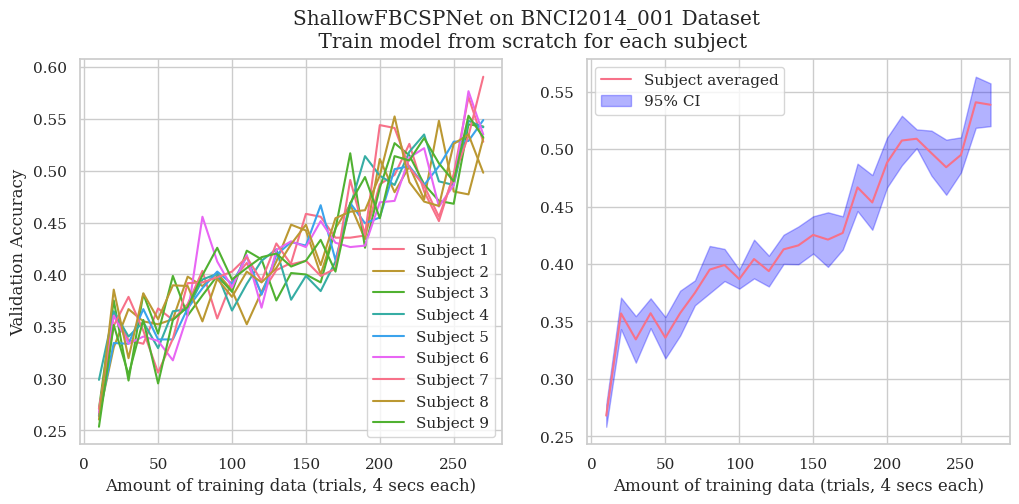

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

for subj_id, subj_res in dict_results.items():
    ax1.plot(subj_res.keys(), subj_res.values(), label=f'Subject {subj_id}')

ax1.legend()
ax1.set_xlabel('Amount of training data (trials, 4 secs each)')
ax1.set_ylabel('Validation Accuracy')

ax2.plot(subject_averaged_df, label='Subject averaged')
ax2.fill_between(subject_averaged_df.index, conf_interval_df[0], conf_interval_df[1], color='b', alpha=0.3, label='95% CI')
ax2.legend()
ax2.set_xlabel('Amount of training data (trials, 4 secs each)')

plt.suptitle('ShallowFBCSPNet on BNCI2014_001 Dataset \n Train model from scratch for each subject')

# plt.savefig(f'{results_dir}//{file_name}.png')